# Master notebook

Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys

module_dir = '../'
print(sys.path)

if module_dir not in sys.path:
    sys.path.append(module_dir)

print(sys.path)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata
from dataloaders import *

from jax import config
config.update("jax_enable_x64", True)

['/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python310.zip', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/lib-dynload', '', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages']
['/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python310.zip', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/lib-dynload', '', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages', '../']


Load data

In [52]:
problem = 'darcy'
n_train = 1000
n_test = 1000
r = 30

if problem == 'darcy':
    dataloader_params = [n_train, n_test, r]
    s = int(((421 - 1) / r) + 1)
    extent = [0, 1, 0, 1]
    x_cmap = 'coolwarm'
    y_cmap = 'viridis'
elif problem == 'ns':
    dataloader_params = [n_train, n_test]
    s = 64
    extent = [0, 2*np.pi, 0, 2*np.pi]
    x_cmap = 'viridis'
    y_cmap = 'viridis'
elif problem == 'helm':
    dataloader_params = [n_train, n_test]
    s = 101
    extent = [0, 1, 0, 1]
    x_cmap = 'viridis'
    y_cmap = 'coolwarm'

dataloader_dict = {'darcy':get_darcy_data, 'ns':get_navier_stokes_data, 'helm':get_helmholtz_data}
x_train, y_train, x_test, y_test, x_grid, y_grid = dataloader_dict[problem](*dataloader_params)

Visualise input and output data

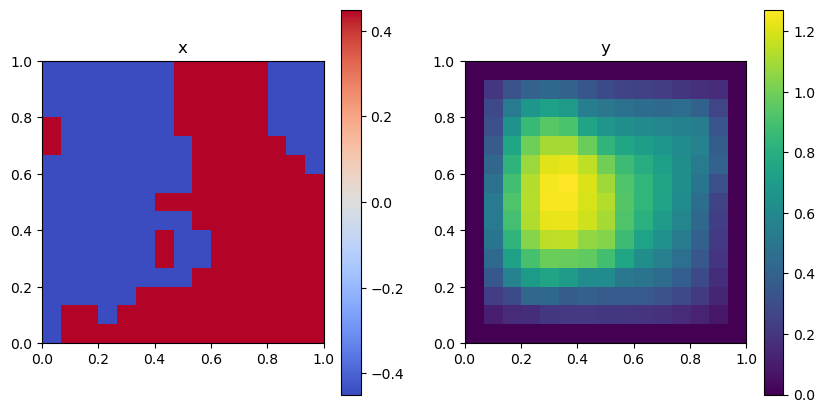

In [53]:
index_to_plot = 12

# print(len(x_train), x_train.shape, x_train[1].shape, y_train.shape)
# print(len(x_test), x_test.shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap=x_cmap)
ax[0].set_title("x")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap=y_cmap)
ax[1].set_title("y")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
plt.show()

Define model

In [54]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

Determine the number of PCs required to capture a given amount of variance

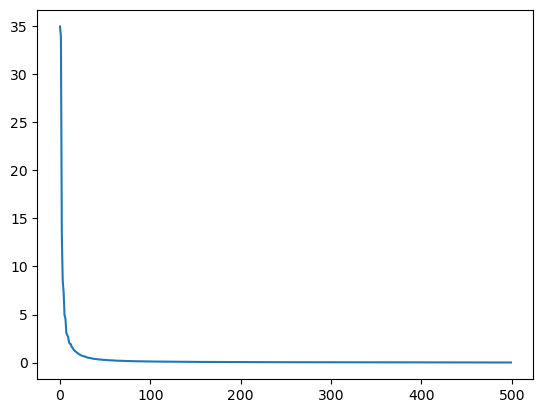

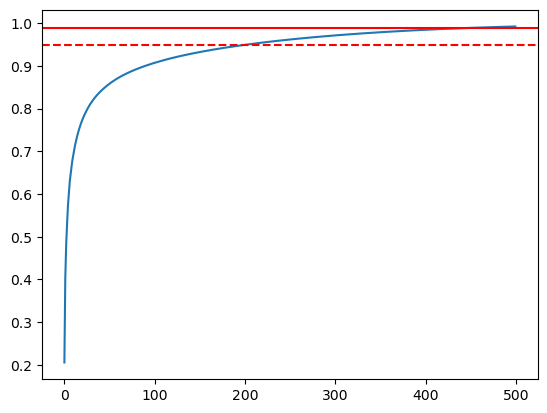

[0.20534495 0.4044839  0.48206088 0.5318035  0.57487935 0.6038418
 0.63076067 0.6488625  0.6656834  0.6812438  0.69352734 0.70493525
 0.7161685  0.7255804  0.7346944  0.7425405  0.7500124  0.75685036
 0.76324195 0.76925725 0.77473223 0.779858   0.78467345 0.7891171
 0.7934277  0.79750013 0.8013314  0.80509603 0.8087659  0.81200886
 0.8151882  0.81815356 0.8210084  0.82382005 0.8265725  0.8290871
 0.83151114 0.83389825 0.8361613  0.8383521  0.84046346 0.84253436
 0.8444885  0.8464208  0.8483063  0.85014904 0.8519138  0.8536426
 0.85531354 0.8569625  0.85855806 0.8601249  0.86167824 0.8631333
 0.86456853 0.86595106 0.86731464 0.86866134 0.8699838  0.8712673
 0.87253124 0.8737244  0.8748902  0.87605023 0.87719494 0.878306
 0.87940735 0.8804889  0.8815488  0.8825629  0.88357216 0.8845754
 0.88555187 0.88650763 0.88746166 0.8883907  0.88931096 0.8902032
 0.89107144 0.8919383  0.8927794  0.89360416 0.89442384 0.89523196
 0.89603007 0.89682525 0.89759505 0.898358   0.89910585 0.89985216
 0.90

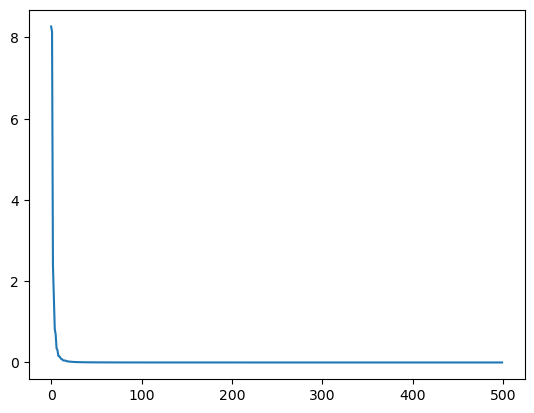

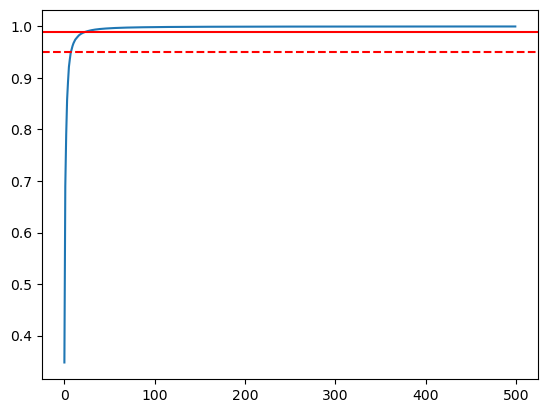

[0.34768012 0.68997663 0.7904099  0.8577863  0.89252675 0.9215199
 0.9361136  0.9488439  0.95561945 0.96203434 0.967143   0.97094345
 0.9743753  0.9766445  0.9786864  0.9807047  0.98265785 0.98400396
 0.9852886  0.98632294 0.98724216 0.9880413  0.9888009  0.98948646
 0.9900657  0.99060804 0.99109423 0.99155426 0.99197066 0.99236226
 0.99275154 0.99309486 0.9934045  0.99369717 0.99395883 0.99420434
 0.99443287 0.9946407  0.9948352  0.9950163  0.995193   0.9953541
 0.99551463 0.9956578  0.995794   0.9959287  0.99605185 0.99617016
 0.99628586 0.99639434 0.9964957  0.9965947  0.99669224 0.99678415
 0.9968702  0.9969505  0.99702823 0.9971041  0.99717736 0.99724895
 0.9973161  0.9973807  0.9974439  0.9975046  0.997563   0.9976187
 0.9976721  0.99772197 0.99777055 0.9978182  0.9978652  0.9979108
 0.9979561  0.99799865 0.99803895 0.99807847 0.99811673 0.99815416
 0.9981903  0.99822533 0.99825805 0.9982895  0.9983206  0.9983507
 0.99838036 0.998409   0.99843675 0.99846447 0.9984916  0.9985179
 

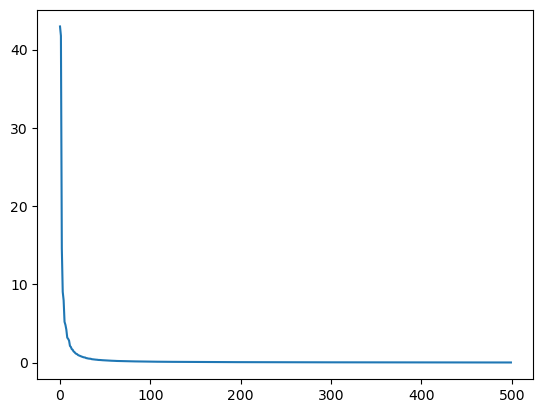

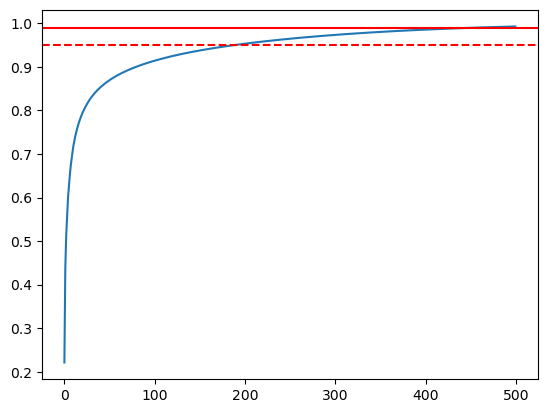

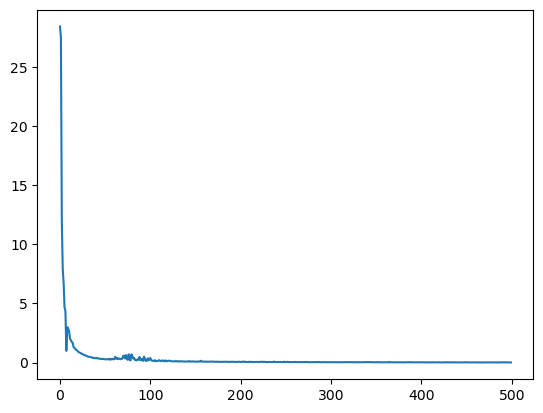

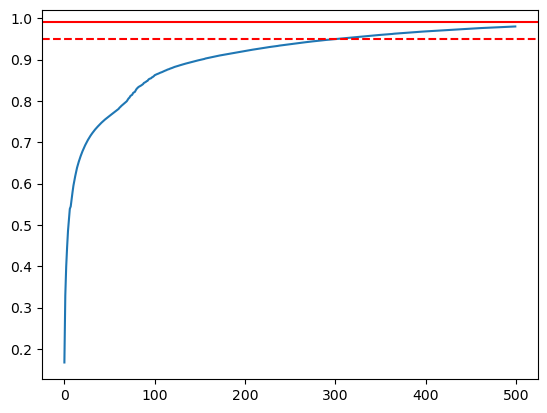

[0.16734954 0.32920707 0.39951264 0.4462137  0.48595373 0.51342781
 0.5389726  0.54480715 0.56246372 0.57936268 0.59516327 0.60712239
 0.61828831 0.62854245 0.63848225 0.64626479 0.65359889 0.66032222
 0.66663315 0.67268388 0.67813359 0.68328039 0.68822092 0.69293604
 0.69728841 0.70154872 0.70551154 0.70924565 0.7128922  0.71621721
 0.71943995 0.72241168 0.72529268 0.72812022 0.73091502 0.73343969
 0.73586549 0.7382571  0.74057034 0.74275818 0.74490901 0.74726217
 0.74929762 0.75131872 0.75326555 0.75517106 0.75693657 0.75874468
 0.76058792 0.76230716 0.7639212  0.76561142 0.76725783 0.76894702
 0.77071347 0.77218233 0.77400091 0.77556475 0.7774209  0.77910645
 0.78077281 0.78362949 0.78558008 0.78791807 0.78962645 0.79167436
 0.79363922 0.79532777 0.79727556 0.79923193 0.80266678 0.80597198
 0.80801339 0.81177234 0.81350326 0.81489132 0.8190116  0.82079757
 0.82183444 0.82594117 0.82935241 0.83140088 0.83371896 0.8349987
 0.83637581 0.83749515 0.83917097 0.84064578 0.84346448 0.84464

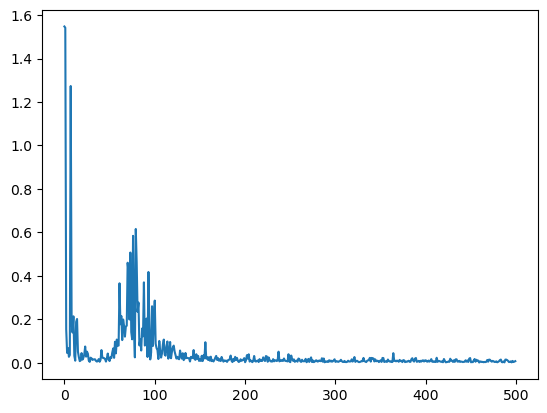

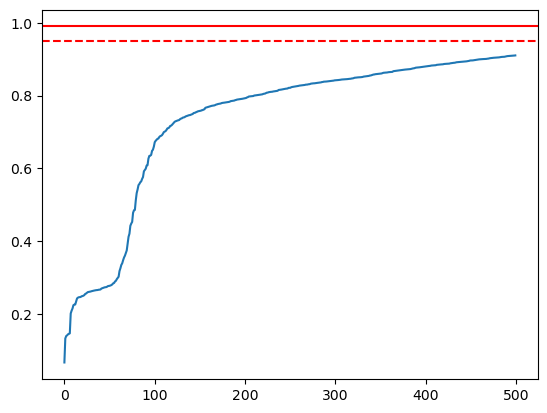

[0.06629946 0.13234117 0.13894143 0.14087715 0.14375909 0.14491828
 0.14644283 0.20100061 0.20887109 0.21482743 0.22396941 0.22531592
 0.22571283 0.23374737 0.24236259 0.24452037 0.24562714 0.24593994
 0.2463732  0.24826704 0.24886735 0.24982113 0.25144493 0.25463434
 0.25583055 0.25800967 0.25977559 0.26019747 0.26036036 0.26134639
 0.26221498 0.26275601 0.26338618 0.26405778 0.2647093  0.26505181
 0.26527047 0.26560529 0.2663169  0.2665     0.26705338 0.26954085
 0.27057439 0.27149244 0.27238499 0.27311343 0.27333032 0.274202
 0.27600863 0.27669729 0.27702319 0.27811121 0.27902662 0.28104955
 0.28386381 0.28482407 0.28895042 0.29078625 0.29534741 0.29868894
 0.30207004 0.31772448 0.32530554 0.33451321 0.33897408 0.34749298
 0.35481688 0.35995674 0.36709015 0.3743767  0.39408693 0.4118946
 0.42040871 0.4421303  0.44816544 0.45277819 0.47779005 0.48463087
 0.48568648 0.51205453 0.53183395 0.54186474 0.55372071 0.55712924
 0.56173077 0.56413469 0.57087637 0.57607644 0.59191699 0.5953000

IndexError: index 0 is out of bounds for axis 0 with size 0

In [45]:
def stand(x):
    return (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)

max_possible_pca = min(x_train.shape[0], x_train.shape[1])

large_n = 500 # used as the upper limit of number of PCs to use, set such that it's larger than what's required
x_var_required = 0.99
y_var_required = 0.99

# these lines are currently just for testing this cell, comment when running full code
# x_train = stand(x_train)
# y_train = stand(y_train)

### separate PCAs
x_pca = PCA(n_components = large_n)
x_pca.fit(x_train)

plt.plot(x_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(x_pca.explained_variance_ratio_))

n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > x_var_required)[0][0]

y_pca = PCA(n_components = large_n)
y_pca.fit(y_train)

plt.plot(y_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(y_pca.explained_variance_ratio_))

m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > y_var_required)[0][0]

print(f'n, m with individually-trained PCAs: {n, m}')

### combined PCA (more features)
combined_pca_full = PCA(n_components = max_possible_pca)
combined_pca = PCA(n_components = large_n)
combined_train = np.concatenate((x_train, y_train), axis = 1)
combined_train_pca_full = combined_pca_full.fit_transform(combined_train)
combined_train_pca = combined_pca.fit_transform(combined_train)
print('does combined pca')

x_pca = PCA(n_components = large_n)
x_pca_full = PCA(n_components = max_possible_pca)
y_pca = PCA(n_components = large_n)
y_pca_full = PCA(n_components = max_possible_pca)

x_pca.components_ = combined_pca.components_[:, :x_train.shape[1]]
x_pca_full.components_ = combined_pca_full.components_[:, :x_train.shape[1]]
x_pca.mean_ = combined_pca.mean_[:x_train.shape[1]]
x_pca_full.mean_ = combined_pca_full.mean_[:x_train.shape[1]]

y_pca.components_ = combined_pca.components_[:, x_train.shape[1]:]
y_pca_full.components_ = combined_pca_full.components_[:, x_train.shape[1]:]
y_pca.mean_ = combined_pca.mean_[x_train.shape[1]:]
y_pca_full.mean_ = combined_pca_full.mean_[x_train.shape[1]:]

def compute_eigenvalues(components, original_data):
    # Reconstruct the covariance matrix from the components
    # `components` are the PCA components for either x_pca or y_pca
    # `original_data` should be x_train or y_train as applicable
    transformed_data = original_data @ components.T
    covariance_matrix = np.cov(transformed_data, rowvar=False)
    eigenvalues = np.diag(covariance_matrix)
    total_variance = np.sum(eigenvalues)

    return eigenvalues

def get_total_var(components, original_data):
    transformed_data = original_data @ components.T
    covariance_matrix = np.cov(transformed_data, rowvar=False)
    eigenvalues = np.diag(covariance_matrix)
    total_variance = np.sum(eigenvalues)

    return total_variance

x_eigenvalues = compute_eigenvalues(x_pca.components_, x_train - x_pca.mean_)
y_eigenvalues = compute_eigenvalues(y_pca.components_, y_train - y_pca.mean_)

x_pca.explained_variance_ratio_ = x_eigenvalues / get_total_var(x_pca_full.components_, x_train - x_pca_full.mean_)
y_pca.explained_variance_ratio_ = y_eigenvalues / get_total_var(y_pca_full.components_, y_train - y_pca_full.mean_)

x_pca.explained_variance_ = x_eigenvalues
y_pca.explained_variance_ = y_eigenvalues

plt.plot(combined_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(combined_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

plt.plot(x_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(x_pca.explained_variance_ratio_))

plt.plot(y_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(y_pca.explained_variance_ratio_))

n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > x_var_required)[0][0]
m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > y_var_required)[0][0]

print(f'n, m with combined PCA (more features): {n, m}')

# combined PCA (more data)
combined_pca = PCA(n_components = large_n)
combined_train = np.concatenate((x_train, y_train), axis = 0)
print(combined_train.shape)
combined_train_pca = combined_pca.fit_transform(combined_train)

plt.plot(combined_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(combined_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

n = np.where(np.cumsum(combined_pca.explained_variance_ratio_) > x_var_required)[0][0]
m = n

print(f'n, m with combined PCA (more data): {n, m}')

# Train

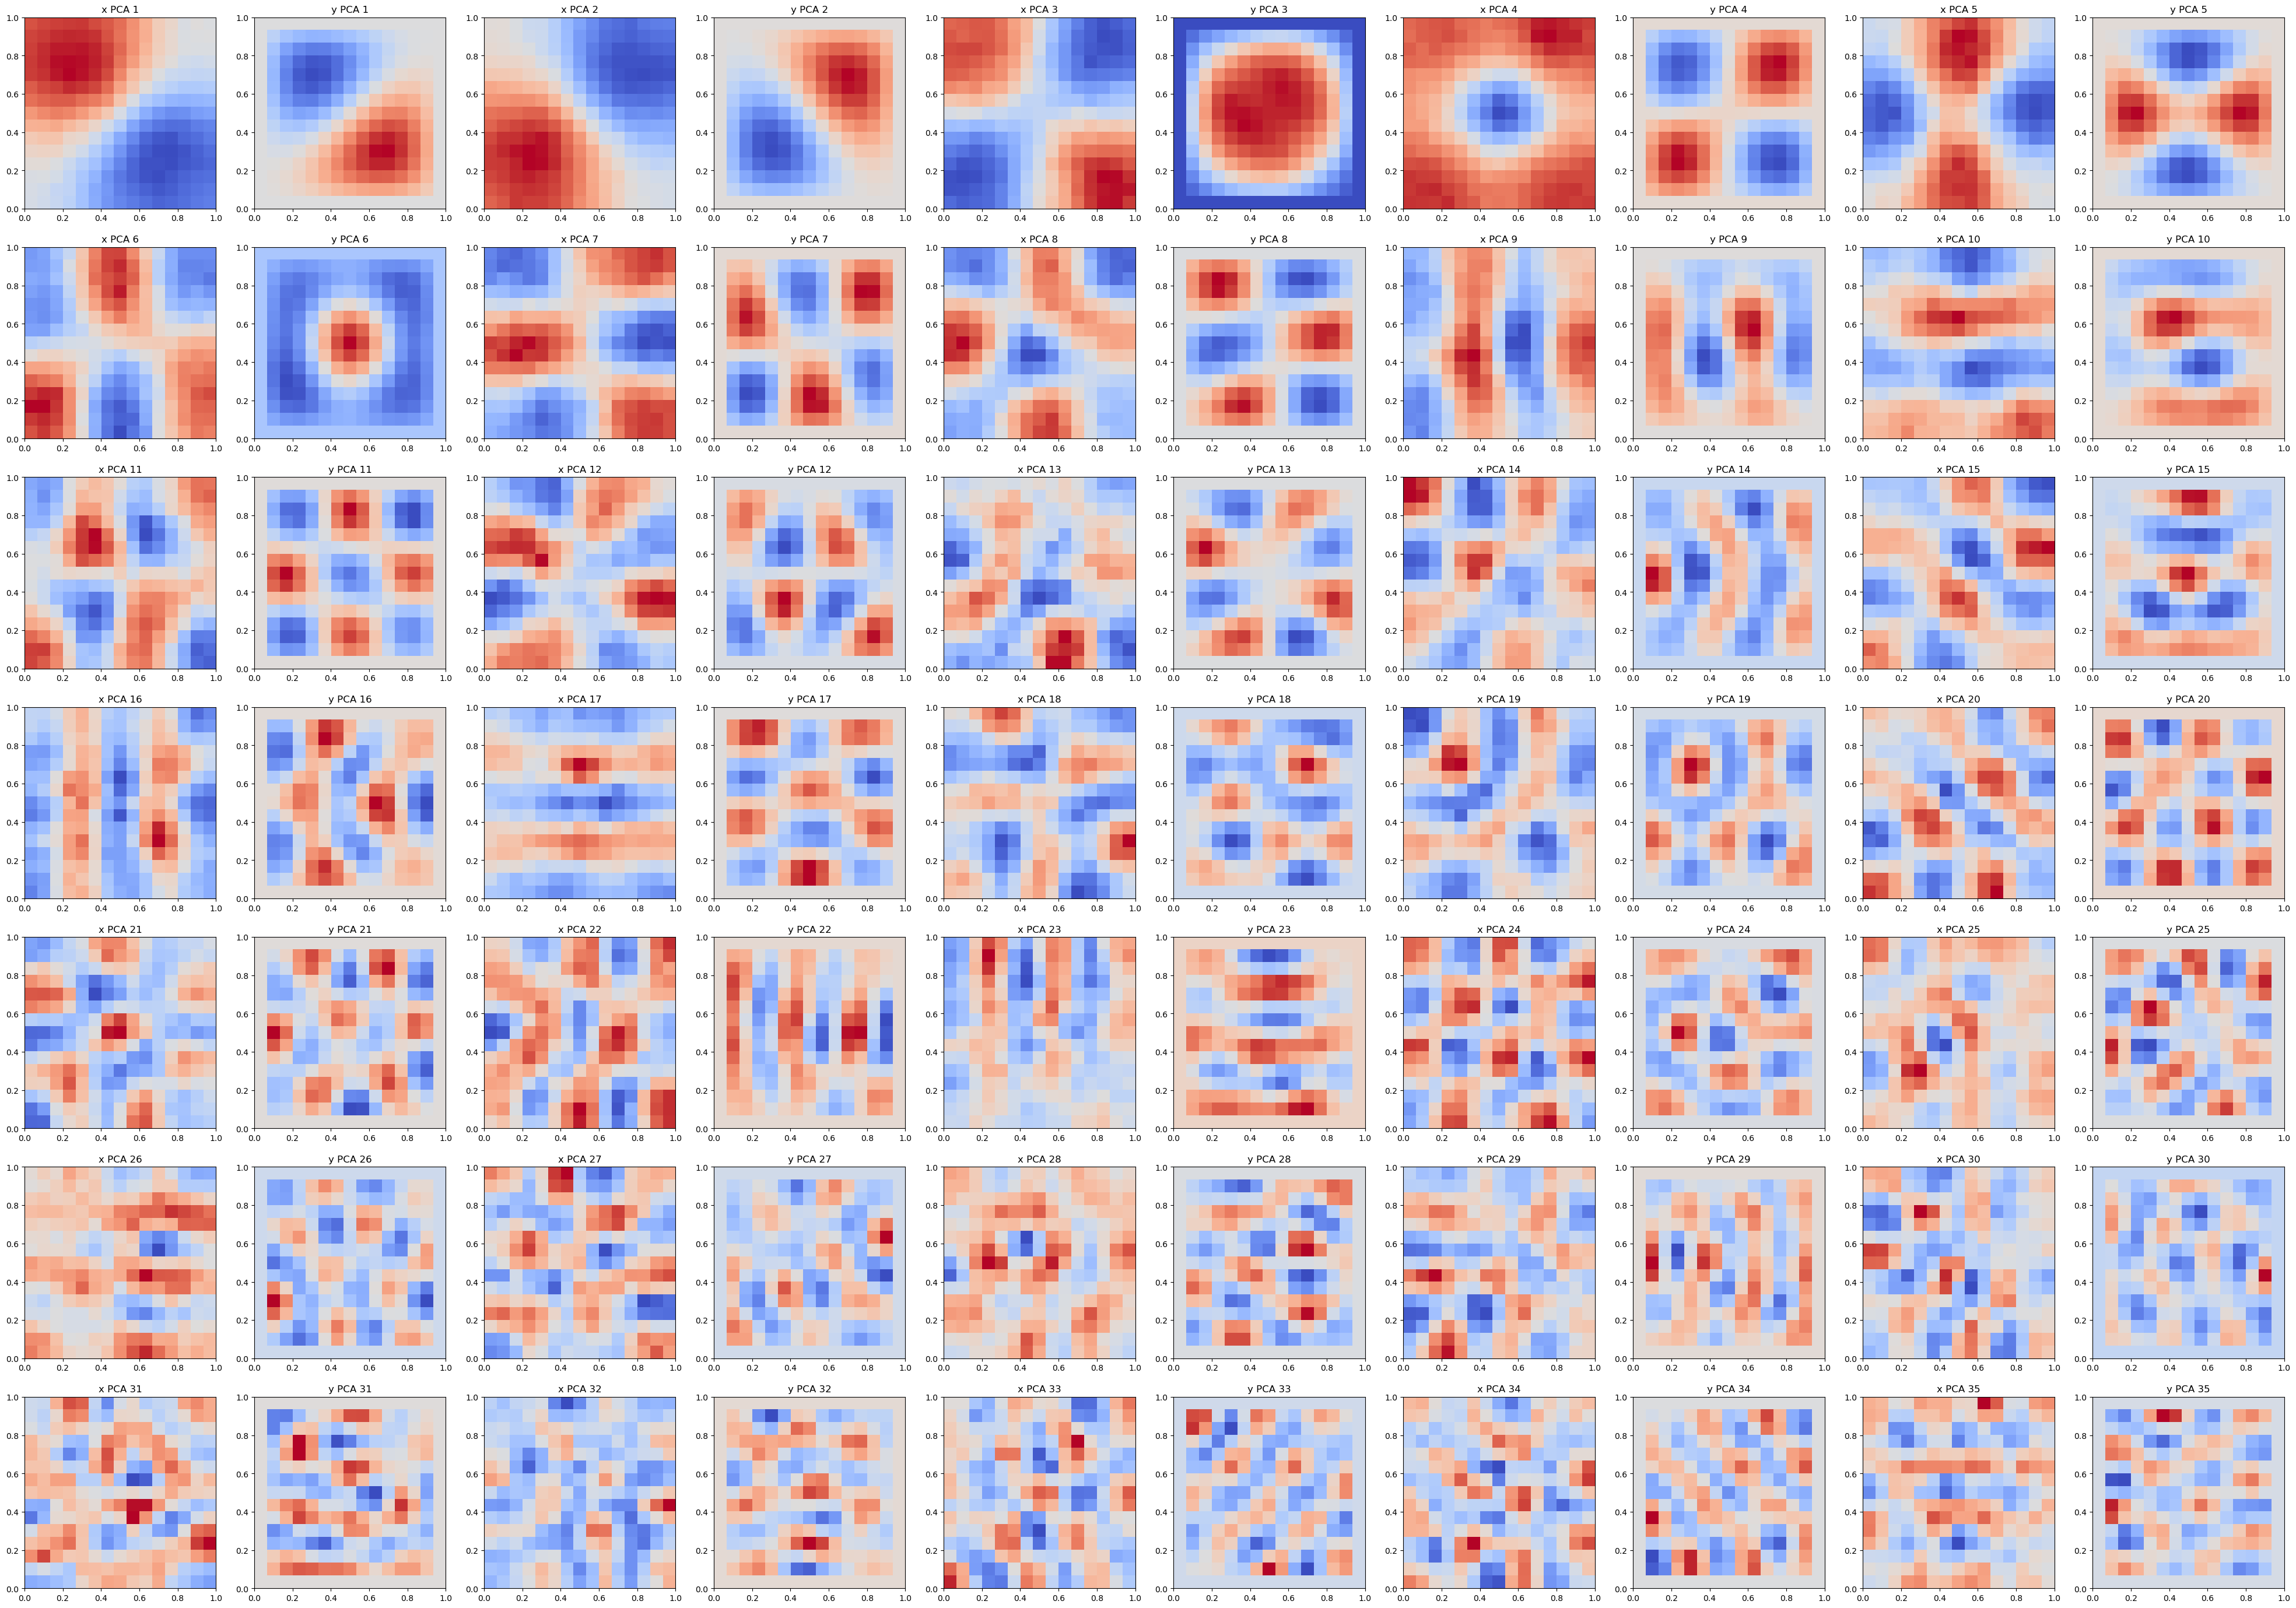

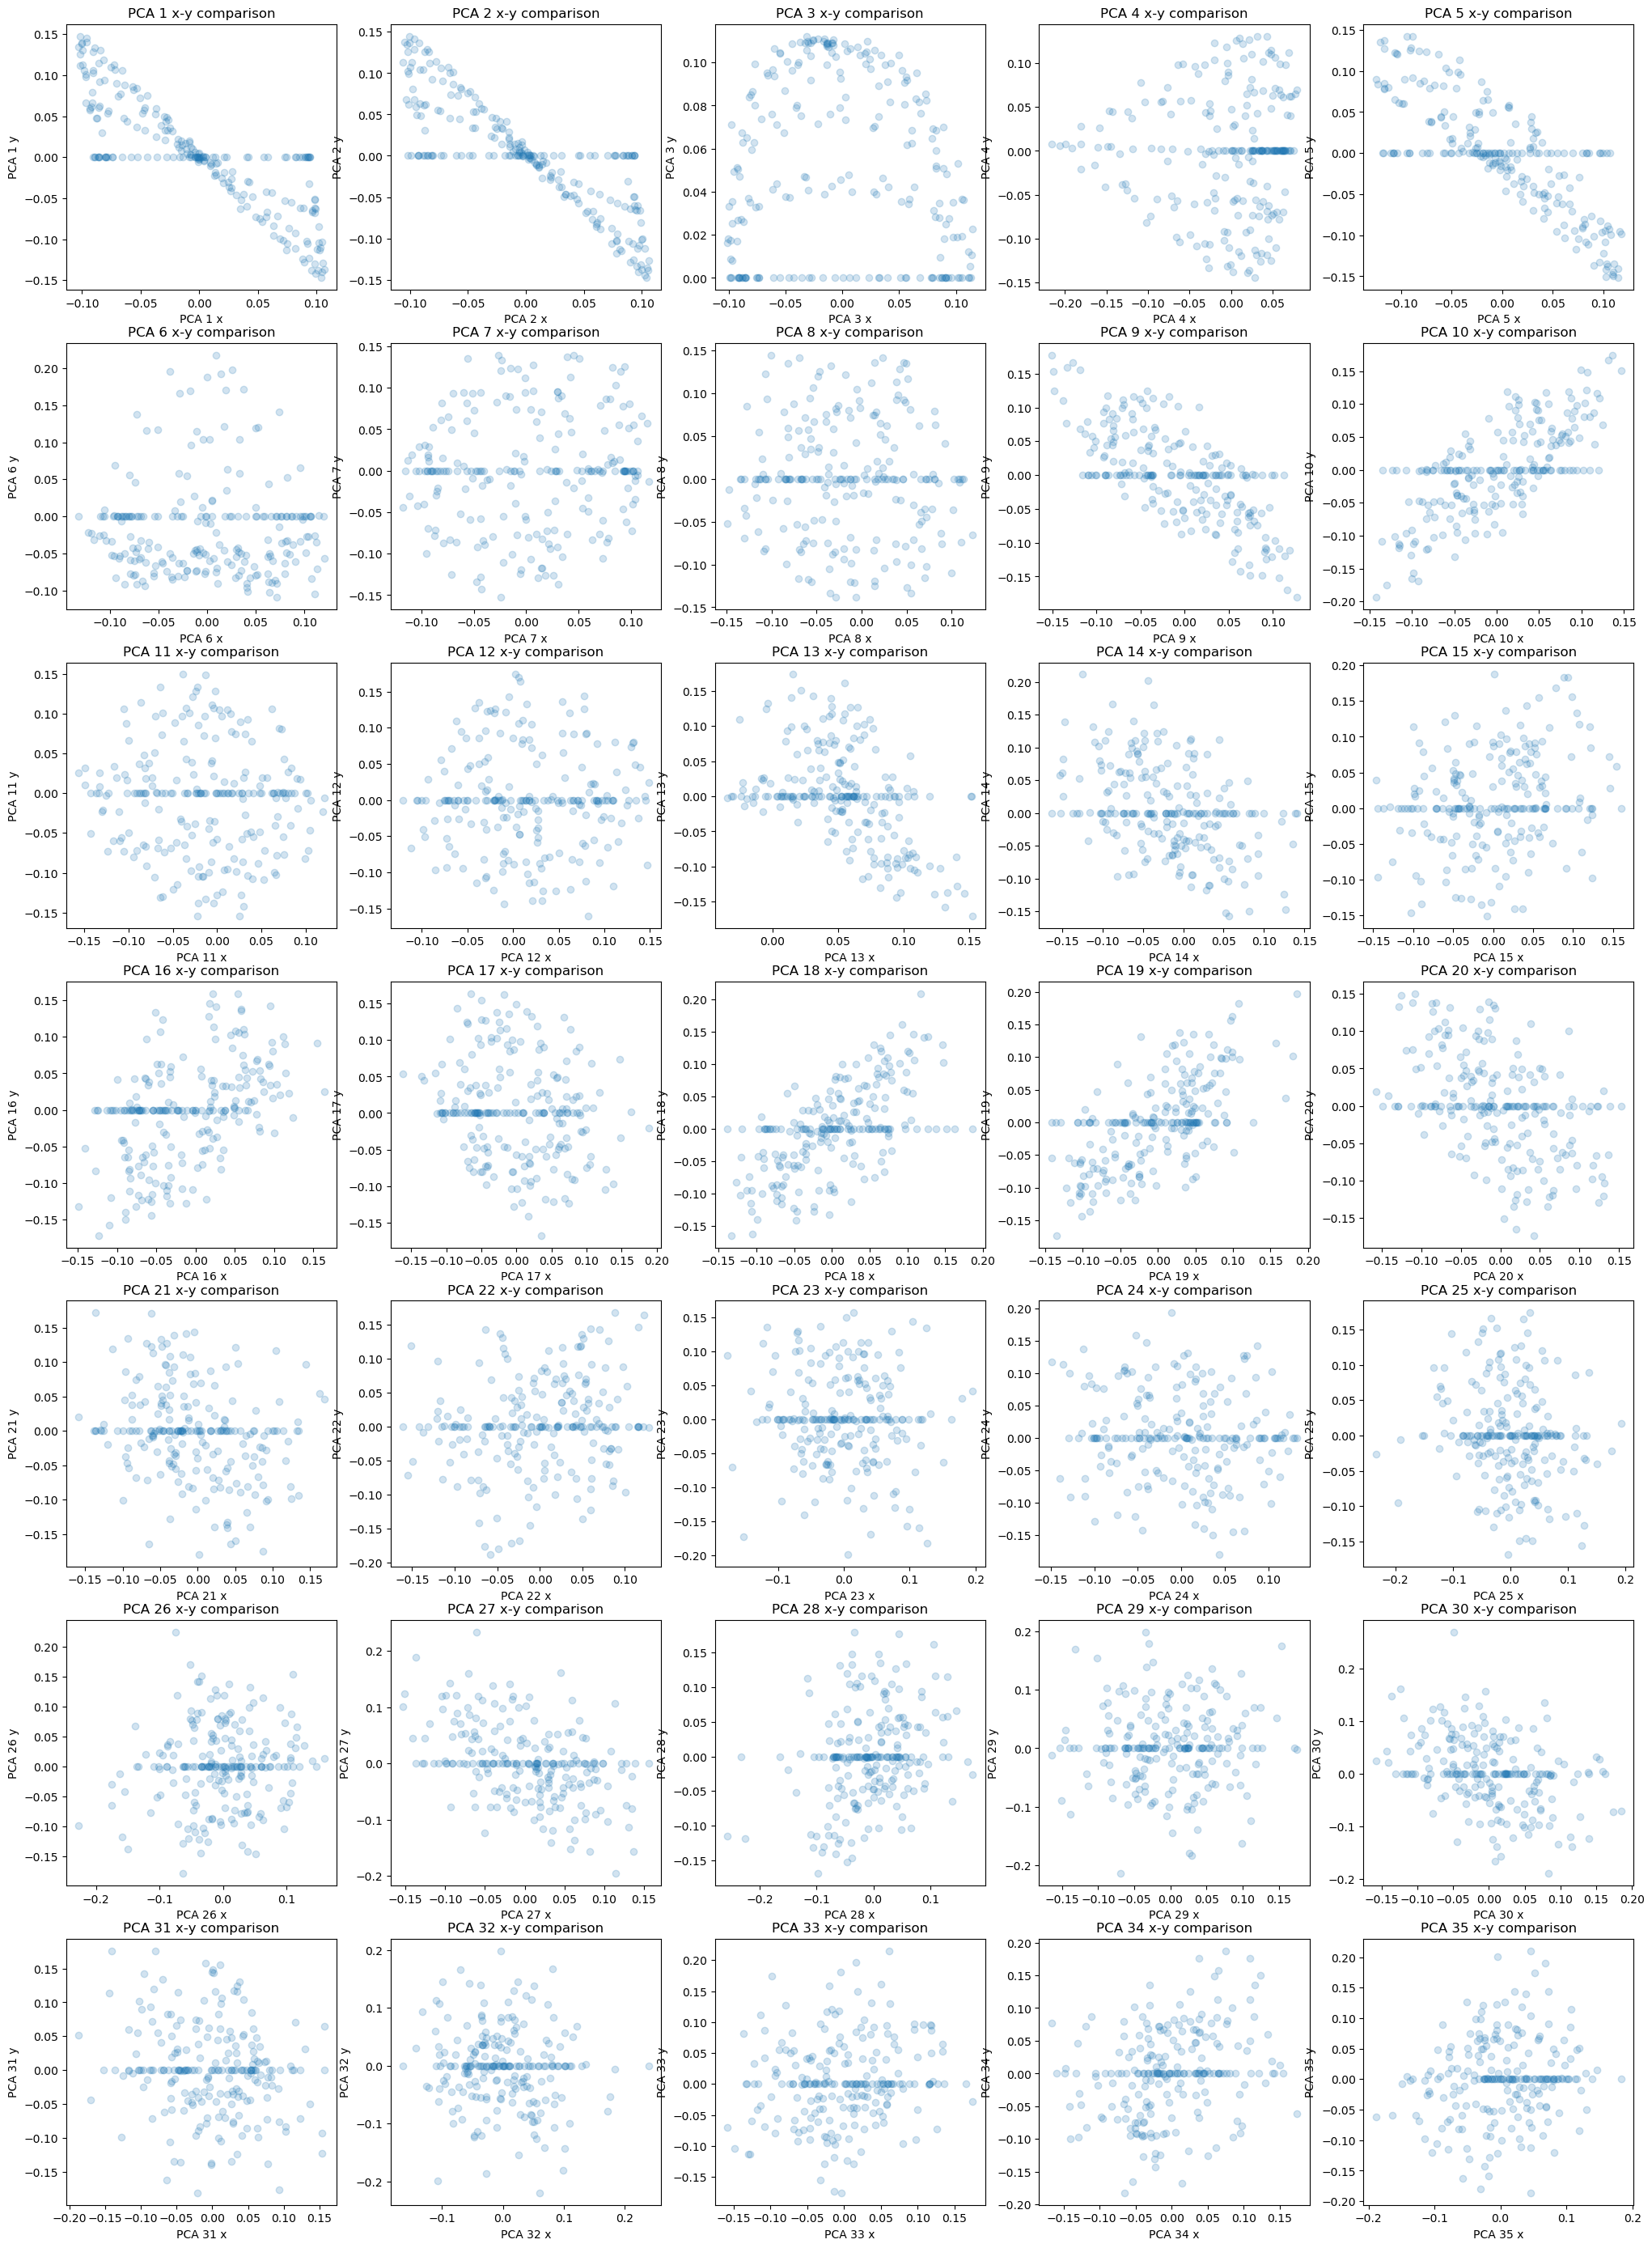

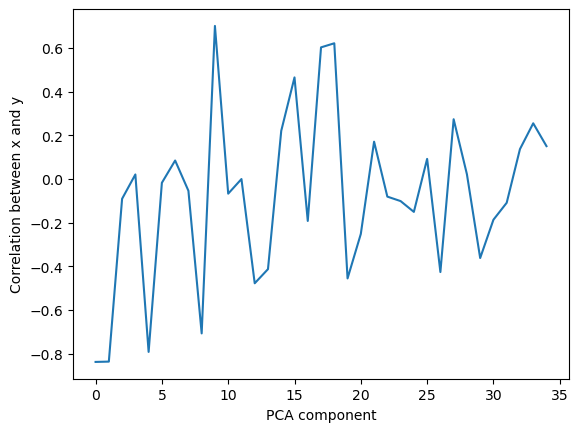

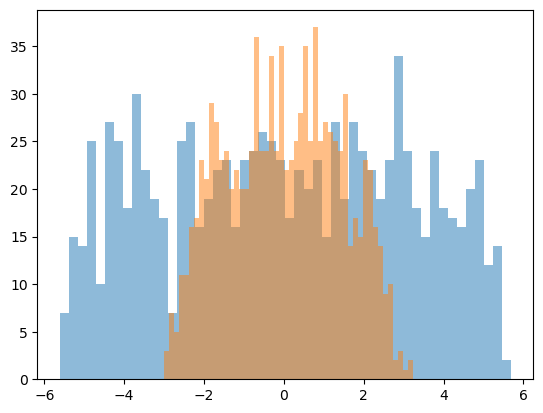

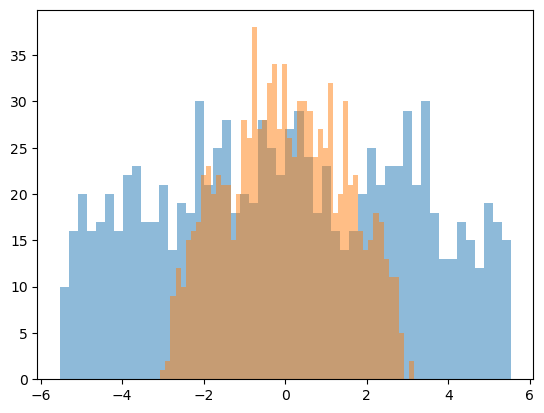

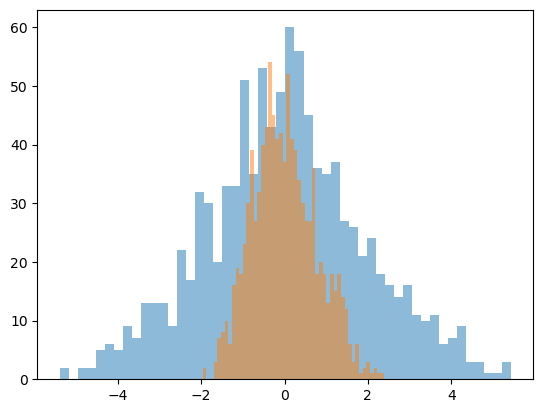

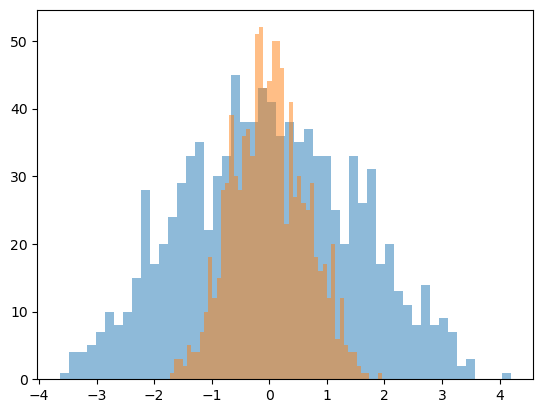

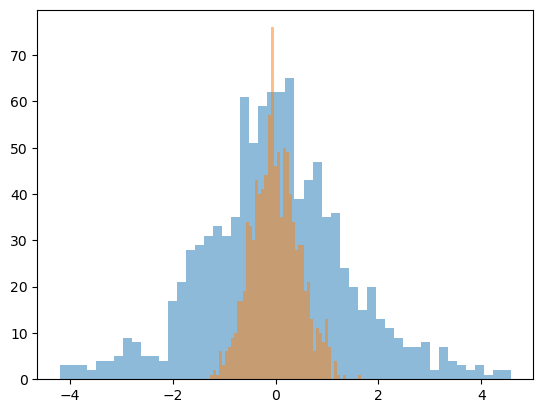

standardising


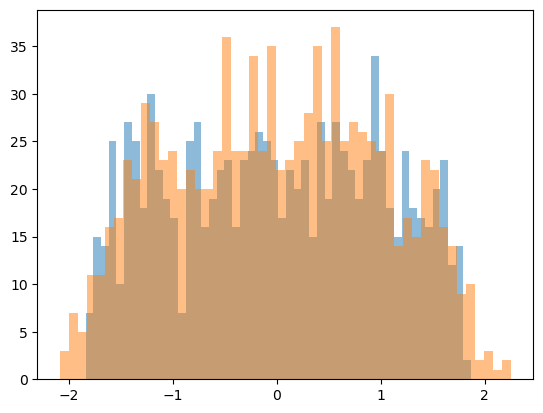

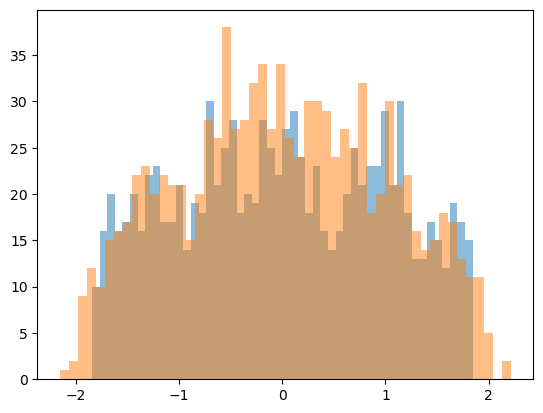

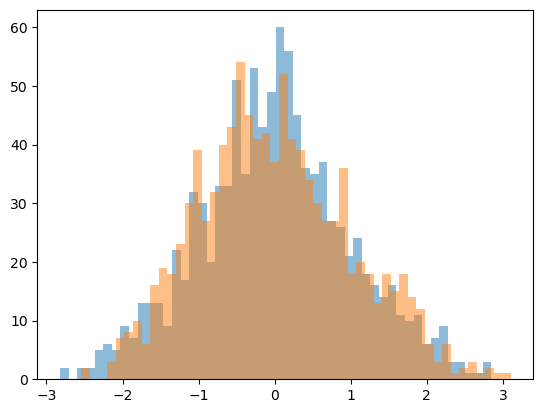

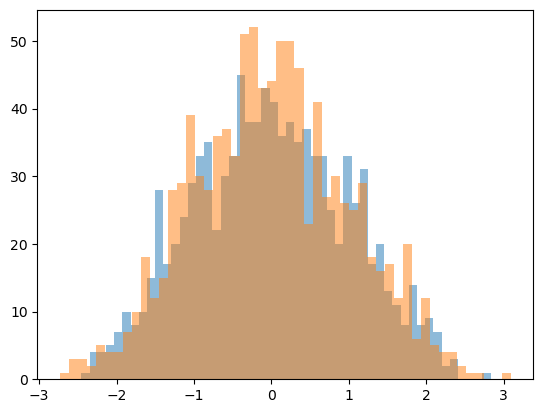

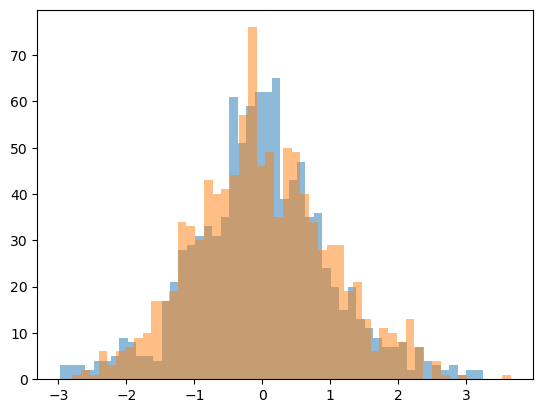

In [55]:
# fitting individual PCAs to x and y

x_train_pca = PCA(n_components=45).fit(x_train)
y_train_pca = PCA(n_components=35).fit(y_train)

fig, ax = plt.subplots(7, 10, figsize=(50, 35))
ax = ax.flatten()

for i in range(0, 70, 2):
    ax[i].imshow(x_train_pca.components_[int(i/2), :].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i].set_title(f"x PCA {int(i/2)+1}")
    ax[i+1].imshow(y_train_pca.components_[int(i/2), :].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i+1].set_title(f"y PCA {int(i/2)+1}")
plt.show()

corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, 35):
    ax[i].plot(x_train_pca.components_[i, :], y_train_pca.components_[i, :], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(x_train_pca.components_[i, :], y_train_pca.components_[i, :])[0, 1])
plt.show()

plt.figure()
plt.plot(corr_list)
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()

x_train_pca = x_train_pca.transform(x_train)
y_train_pca = y_train_pca.transform(y_train)

for i in range(5):
    plt.figure()
    plt.hist(x_train_pca[:, i], bins=50, label = f'x_train_pca {i+1}', alpha=0.5)
    plt.hist(y_train_pca[:, i], bins=50, label = f'y_train_pca {i+1}', alpha=0.5)
    plt.show()

print('standardising')

for i in range(5):
    x_train_pca_stand_i = (x_train_pca[:, i] - x_train_pca[:, i].mean(axis = 0))/x_train_pca[:, i].std(axis = 0)
    y_train_pca_stand_i = (y_train_pca[:, i] - y_train_pca[:, i].mean(axis = 0))/y_train_pca[:, i].std(axis = 0)
    plt.figure()
    plt.hist(x_train_pca_stand_i, bins=50, label = f'x_train_pca_stand {i+1}', alpha=0.5)
    plt.hist(y_train_pca_stand_i, bins=50, label = f'y_train_pca_stand {i+1}', alpha=0.5)
    plt.show()


(1000, 450)


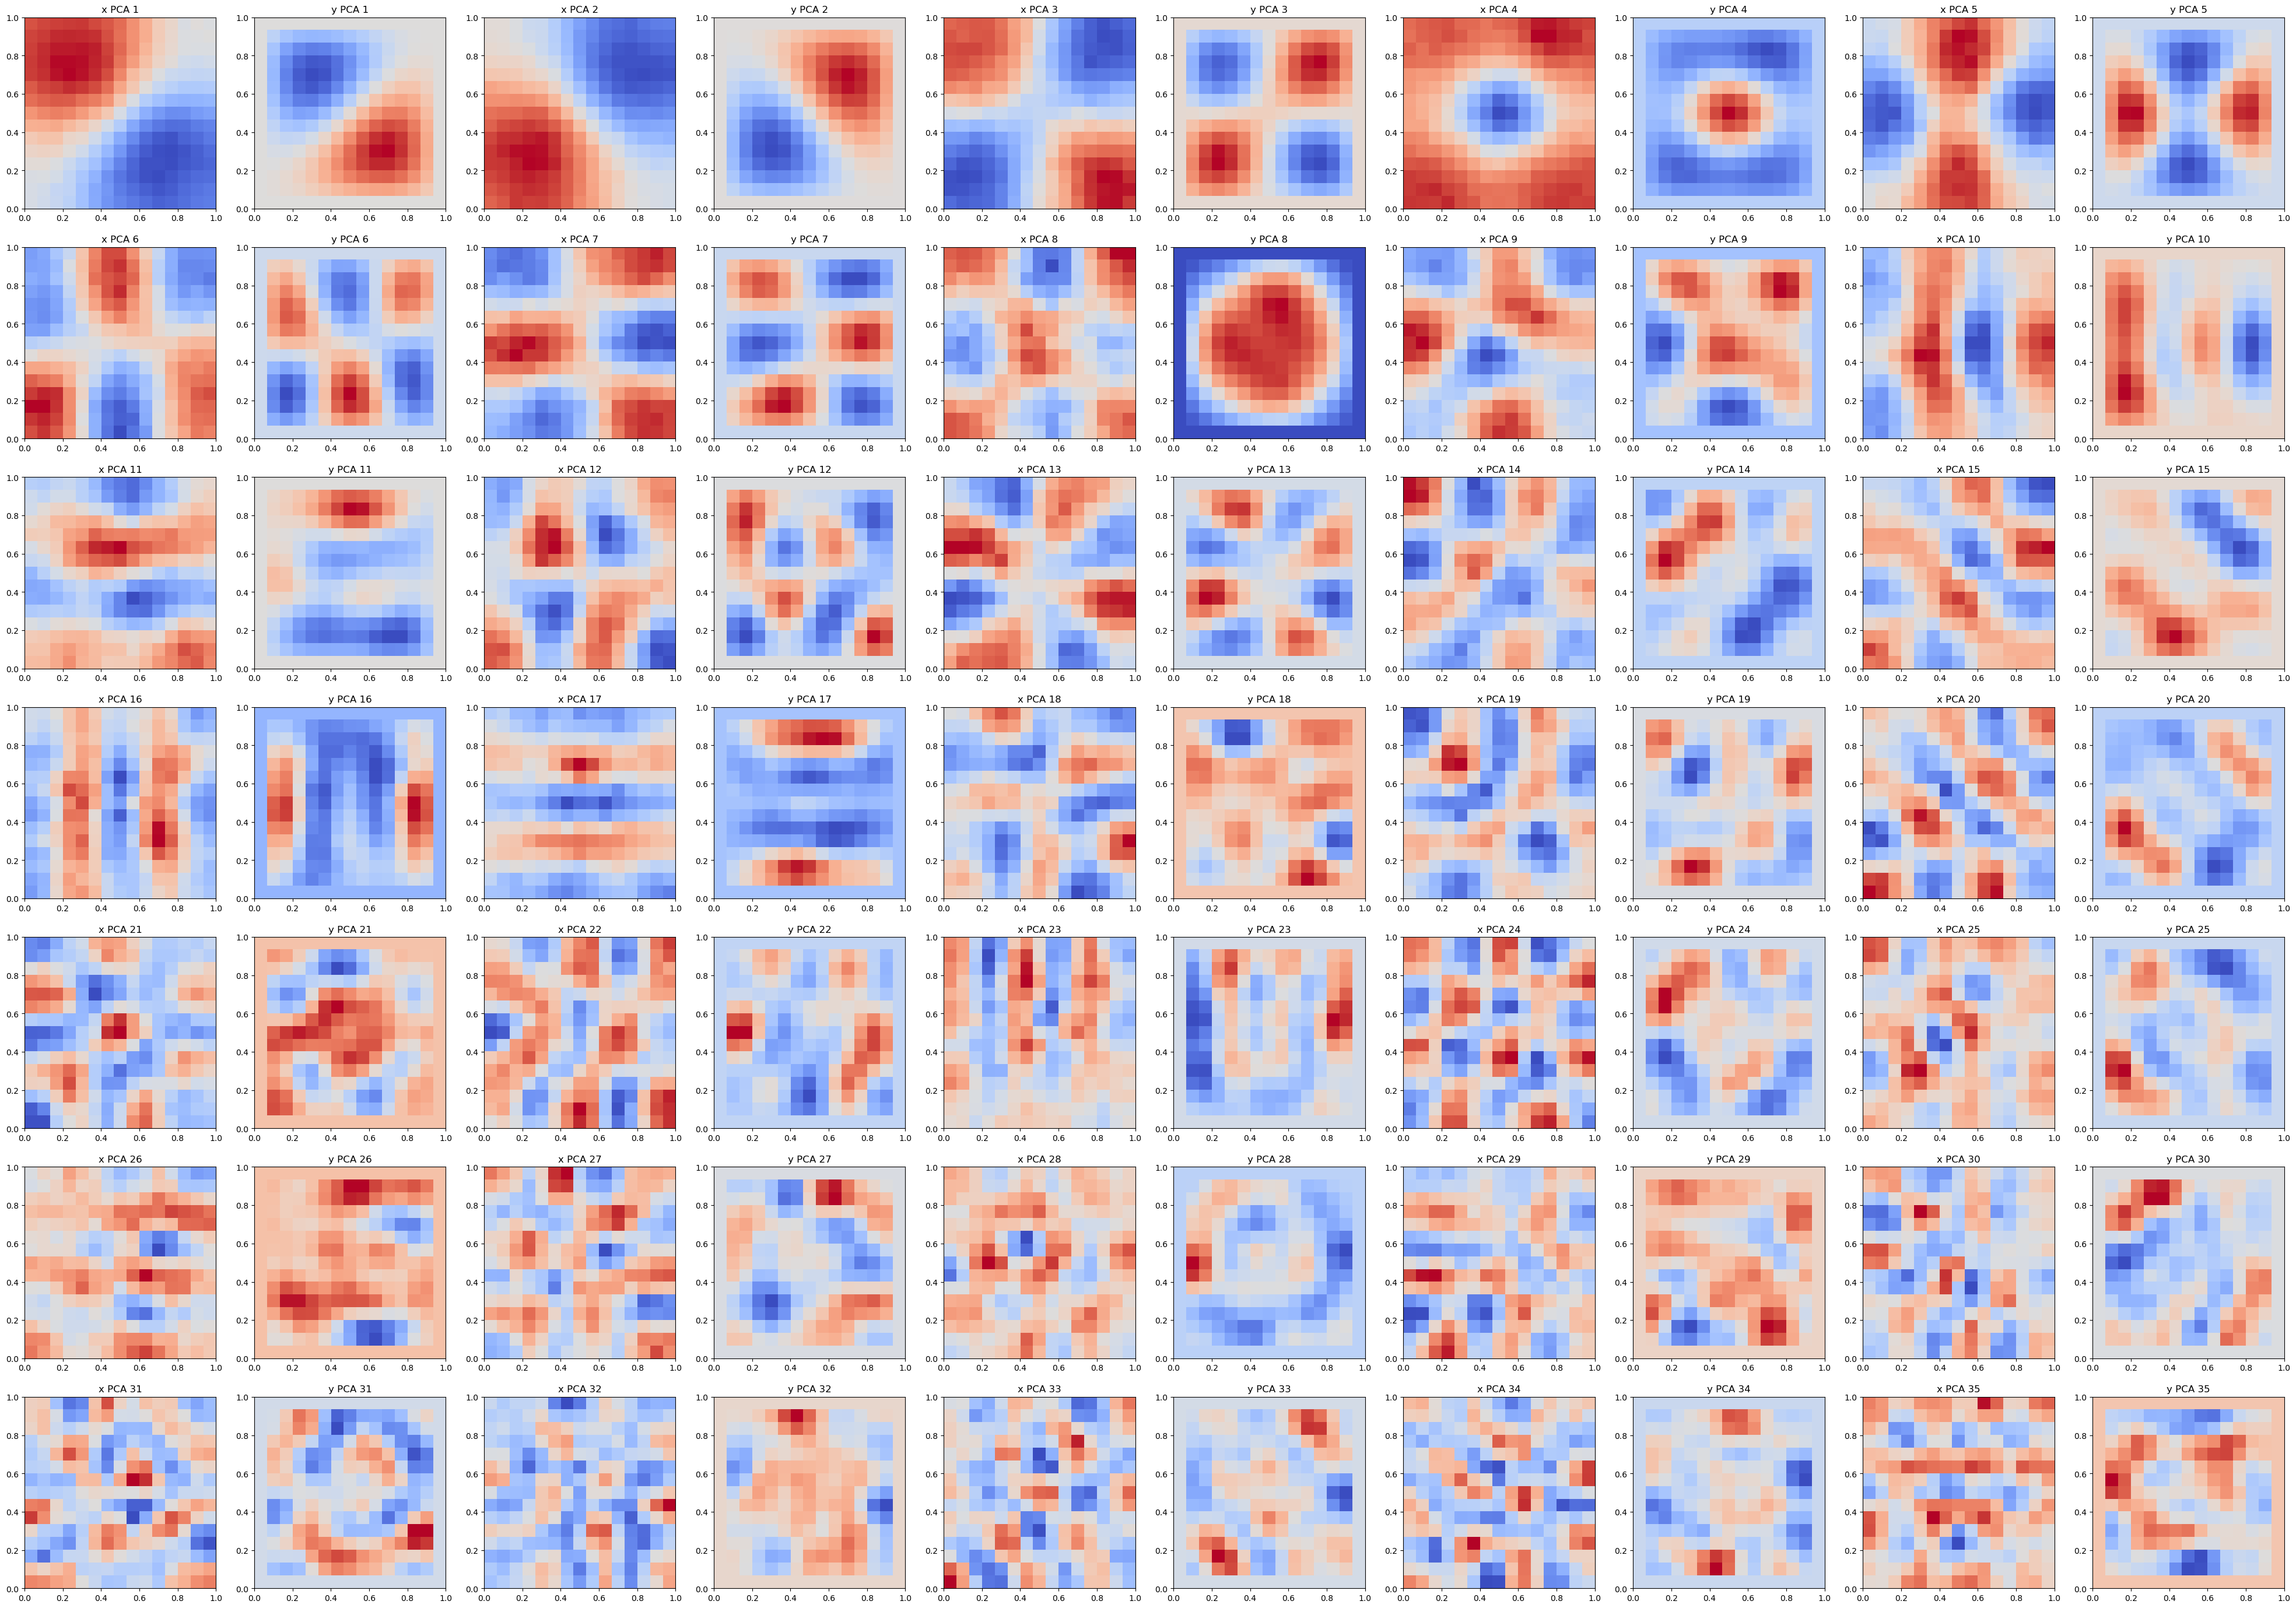

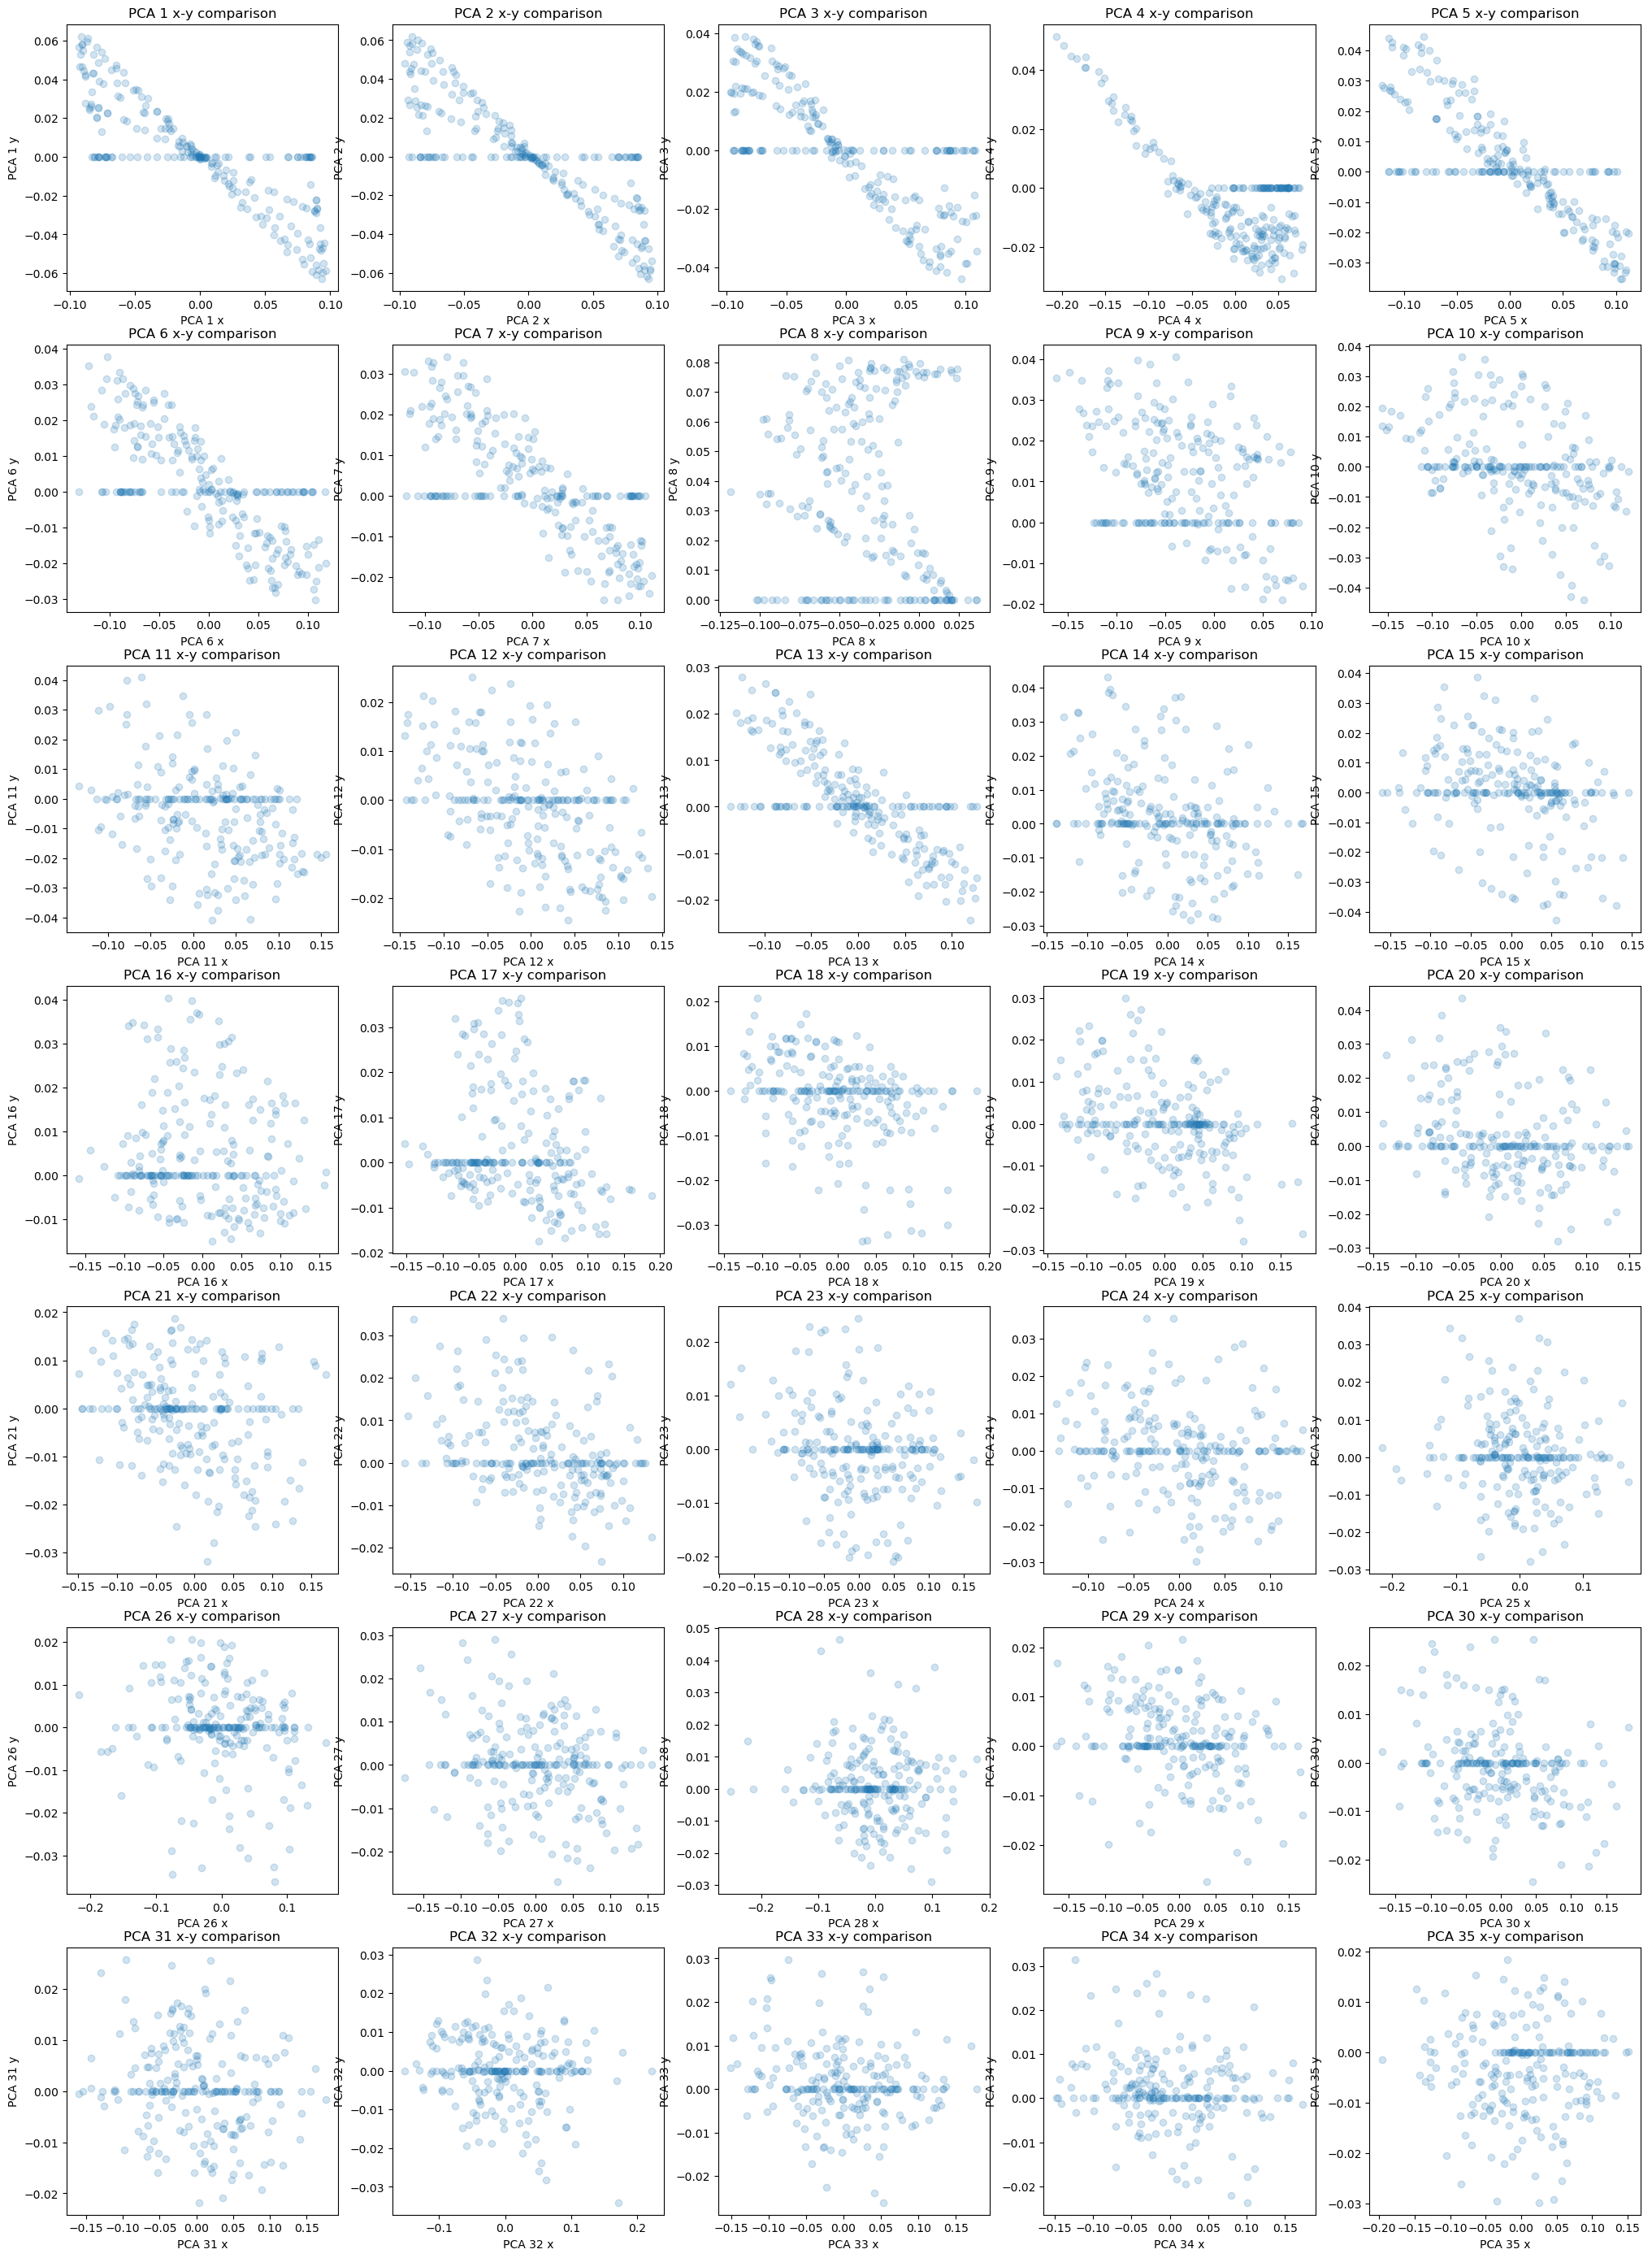

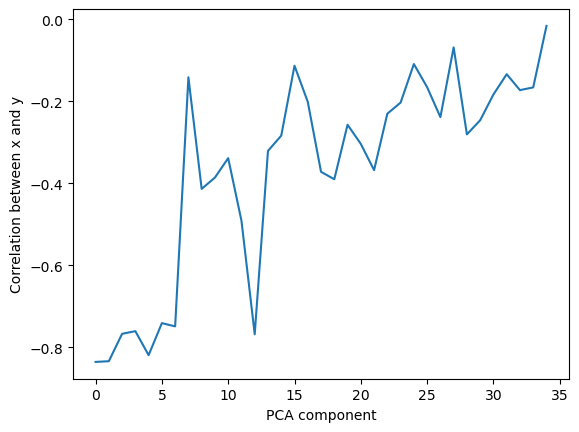

(1000, 45)


In [56]:
# fitting PCA to combined x and y (more features)

combined_train = np.concatenate((x_train, y_train), axis = 1)
print(combined_train.shape)

combined_train_pca = PCA(n_components=45).fit(combined_train)

fig, ax = plt.subplots(7, 10, figsize=(50, 35))
ax = ax.flatten()

for i in range(0, 70, 2):
    ax[i].imshow(combined_train_pca.components_[int(i/2), :x_train.shape[1]].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i].set_title(f"x PCA {int(i/2)+1}")
    ax[i+1].imshow(combined_train_pca.components_[int(i/2), x_train.shape[1]:].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i+1].set_title(f"y PCA {int(i/2)+1}")
plt.show()

corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, 35):
    ax[i].plot(combined_train_pca.components_[i, :x_train.shape[1]], combined_train_pca.components_[i, x_train.shape[1]:], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(combined_train_pca.components_[i, :x_train.shape[1]], combined_train_pca.components_[i, x_train.shape[1]:])[0, 1])
plt.show()

plt.figure()
plt.plot(corr_list)
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()

combined_train_pca = combined_train_pca.transform(combined_train)
print(combined_train_pca.shape)

(2000, 225)


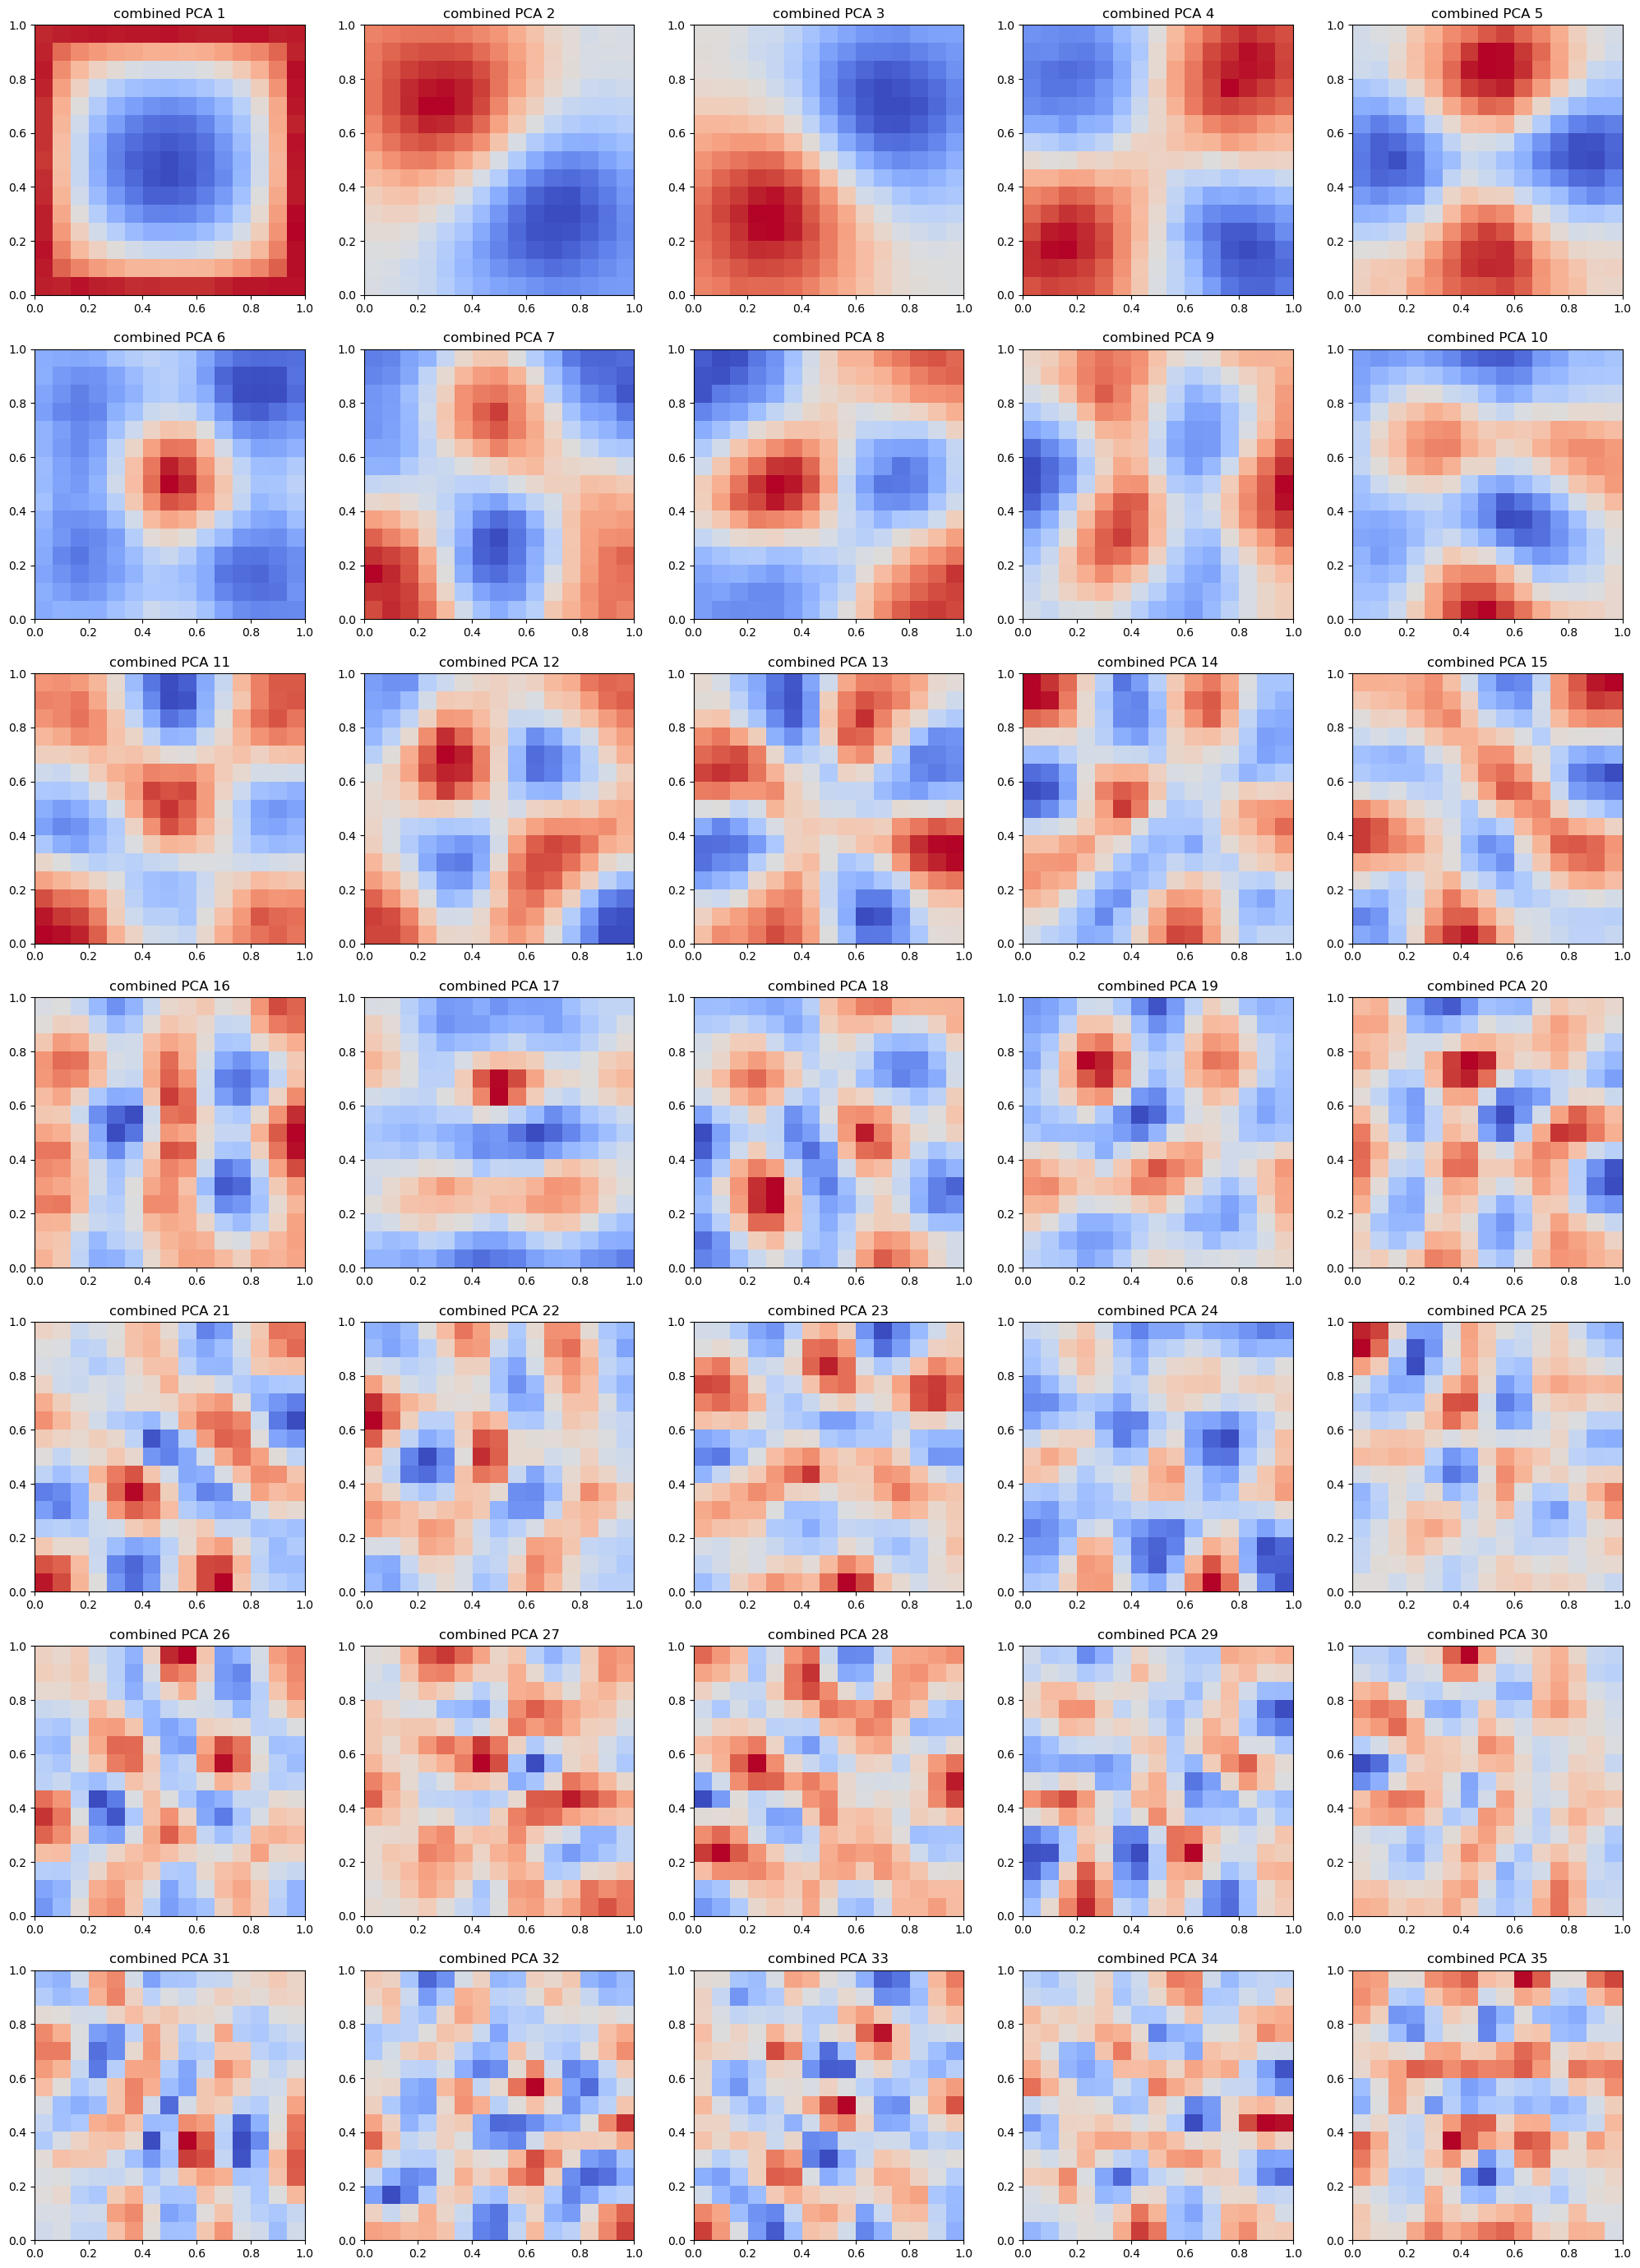

(2000, 45)


In [57]:
# fit PCA to combined x and y (more data)

combined_train = np.concatenate((x_train, y_train), axis = 0)
print(combined_train.shape)

combined_train_pca = PCA(n_components=45).fit(combined_train)

fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()

for i in range(0, 35):
    ax[i].imshow(combined_train_pca.components_[i, :].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i].set_title(f"combined PCA {i+1}")
plt.show()

combined_train_pca = combined_train_pca.transform(combined_train)
print(combined_train_pca.shape)

fitting my custom joint PCA with tunable parameter $\rho$

  0%|          | 0/5 [00:00<?, ?it/s]

initial guess: [ 7.60888805e-02  7.43313765e-02  3.15003067e-01 -4.65747601e-02
 -2.84532430e-02  6.88254109e-02  5.58796527e-02  7.16322645e-02
  2.29392033e-03  7.91439240e-02  2.03997426e-02 -5.62403119e-02
  8.77000652e-03  7.12567439e-02  8.90732911e-02 -7.58117494e-03
 -1.13812175e-01  1.47532825e-02  3.42781962e-02  1.40731773e-01
  9.65092008e-02 -8.86407051e-02  1.45282741e-02  1.50681605e-02
  1.02641282e-01  2.70169049e-02 -1.23773907e-01  4.14553398e-02
 -7.69680026e-02 -3.74656034e-02 -4.72063456e-02 -1.16327191e-02
 -3.08009365e-02 -2.01948678e-02  7.98718834e-02  7.09636242e-02
 -6.64530087e-02  2.51581492e-02  8.56367879e-02 -1.95642015e-02
 -1.26962762e-01  2.77220133e-02 -8.50845957e-02  1.94881127e-04
  1.24681921e-01  1.02407471e-01 -1.62805206e-02 -1.13326092e-01
  5.47431834e-02  8.13711999e-02 -3.38274893e-02  1.02338596e-01
  1.18517754e-02 -8.82668887e-02  3.35781500e-02 -1.00765963e-01
  6.85366367e-02 -1.03682241e-01 -6.64313660e-03 -6.65468193e-02
 -2.675397

 20%|██        | 1/5 [00:44<02:57, 44.30s/it]

initial guess: [ 7.60888805e-02  7.43313765e-02  3.15003067e-01 -4.65747601e-02
 -2.84532430e-02  6.88254109e-02  5.58796527e-02  7.16322645e-02
  2.29392033e-03  7.91439240e-02  2.03997426e-02 -5.62403119e-02
  8.77000652e-03  7.12567439e-02  8.90732911e-02 -7.58117494e-03
 -1.13812175e-01  1.47532825e-02  3.42781962e-02  1.40731773e-01
  9.65092008e-02 -8.86407051e-02  1.45282741e-02  1.50681605e-02
  1.02641282e-01  2.70169049e-02 -1.23773907e-01  4.14553398e-02
 -7.69680026e-02 -3.74656034e-02 -4.72063456e-02 -1.16327191e-02
 -3.08009365e-02 -2.01948678e-02  7.98718834e-02  7.09636242e-02
 -6.64530087e-02  2.51581492e-02  8.56367879e-02 -1.95642015e-02
 -1.26962762e-01  2.77220133e-02 -8.50845957e-02  1.94881127e-04
  1.24681921e-01  1.02407471e-01 -1.62805206e-02 -1.13326092e-01
  5.47431834e-02  8.13711999e-02 -3.38274893e-02  1.02338596e-01
  1.18517754e-02 -8.82668887e-02  3.35781500e-02 -1.00765963e-01
  6.85366367e-02 -1.03682241e-01 -6.64313660e-03 -6.65468193e-02
 -2.675397

 40%|████      | 2/5 [01:30<02:17, 45.70s/it]

initial guess: [ 7.60888805e-02  7.43313765e-02  3.15003067e-01 -4.65747601e-02
 -2.84532430e-02  6.88254109e-02  5.58796527e-02  7.16322645e-02
  2.29392033e-03  7.91439240e-02  2.03997426e-02 -5.62403119e-02
  8.77000652e-03  7.12567439e-02  8.90732911e-02 -7.58117494e-03
 -1.13812175e-01  1.47532825e-02  3.42781962e-02  1.40731773e-01
  9.65092008e-02 -8.86407051e-02  1.45282741e-02  1.50681605e-02
  1.02641282e-01  2.70169049e-02 -1.23773907e-01  4.14553398e-02
 -7.69680026e-02 -3.74656034e-02 -4.72063456e-02 -1.16327191e-02
 -3.08009365e-02 -2.01948678e-02  7.98718834e-02  7.09636242e-02
 -6.64530087e-02  2.51581492e-02  8.56367879e-02 -1.95642015e-02
 -1.26962762e-01  2.77220133e-02 -8.50845957e-02  1.94881127e-04
  1.24681921e-01  1.02407471e-01 -1.62805206e-02 -1.13326092e-01
  5.47431834e-02  8.13711999e-02 -3.38274893e-02  1.02338596e-01
  1.18517754e-02 -8.82668887e-02  3.35781500e-02 -1.00765963e-01
  6.85366367e-02 -1.03682241e-01 -6.64313660e-03 -6.65468193e-02
 -2.675397

 60%|██████    | 3/5 [01:45<01:02, 31.45s/it]

initial guess: [ 7.60888805e-02  7.43313765e-02  3.15003067e-01 -4.65747601e-02
 -2.84532430e-02  6.88254109e-02  5.58796527e-02  7.16322645e-02
  2.29392033e-03  7.91439240e-02  2.03997426e-02 -5.62403119e-02
  8.77000652e-03  7.12567439e-02  8.90732911e-02 -7.58117494e-03
 -1.13812175e-01  1.47532825e-02  3.42781962e-02  1.40731773e-01
  9.65092008e-02 -8.86407051e-02  1.45282741e-02  1.50681605e-02
  1.02641282e-01  2.70169049e-02 -1.23773907e-01  4.14553398e-02
 -7.69680026e-02 -3.74656034e-02 -4.72063456e-02 -1.16327191e-02
 -3.08009365e-02 -2.01948678e-02  7.98718834e-02  7.09636242e-02
 -6.64530087e-02  2.51581492e-02  8.56367879e-02 -1.95642015e-02
 -1.26962762e-01  2.77220133e-02 -8.50845957e-02  1.94881127e-04
  1.24681921e-01  1.02407471e-01 -1.62805206e-02 -1.13326092e-01
  5.47431834e-02  8.13711999e-02 -3.38274893e-02  1.02338596e-01
  1.18517754e-02 -8.82668887e-02  3.35781500e-02 -1.00765963e-01
  6.85366367e-02 -1.03682241e-01 -6.64313660e-03 -6.65468193e-02
 -2.675397

 80%|████████  | 4/5 [01:56<00:23, 23.24s/it]

initial guess: [ 7.60888805e-02  7.43313765e-02  3.15003067e-01 -4.65747601e-02
 -2.84532430e-02  6.88254109e-02  5.58796527e-02  7.16322645e-02
  2.29392033e-03  7.91439240e-02  2.03997426e-02 -5.62403119e-02
  8.77000652e-03  7.12567439e-02  8.90732911e-02 -7.58117494e-03
 -1.13812175e-01  1.47532825e-02  3.42781962e-02  1.40731773e-01
  9.65092008e-02 -8.86407051e-02  1.45282741e-02  1.50681605e-02
  1.02641282e-01  2.70169049e-02 -1.23773907e-01  4.14553398e-02
 -7.69680026e-02 -3.74656034e-02 -4.72063456e-02 -1.16327191e-02
 -3.08009365e-02 -2.01948678e-02  7.98718834e-02  7.09636242e-02
 -6.64530087e-02  2.51581492e-02  8.56367879e-02 -1.95642015e-02
 -1.26962762e-01  2.77220133e-02 -8.50845957e-02  1.94881127e-04
  1.24681921e-01  1.02407471e-01 -1.62805206e-02 -1.13326092e-01
  5.47431834e-02  8.13711999e-02 -3.38274893e-02  1.02338596e-01
  1.18517754e-02 -8.82668887e-02  3.35781500e-02 -1.00765963e-01
  6.85366367e-02 -1.03682241e-01 -6.64313660e-03 -6.65468193e-02
 -2.675397

100%|██████████| 5/5 [02:00<00:00, 24.11s/it]


(5, 400)


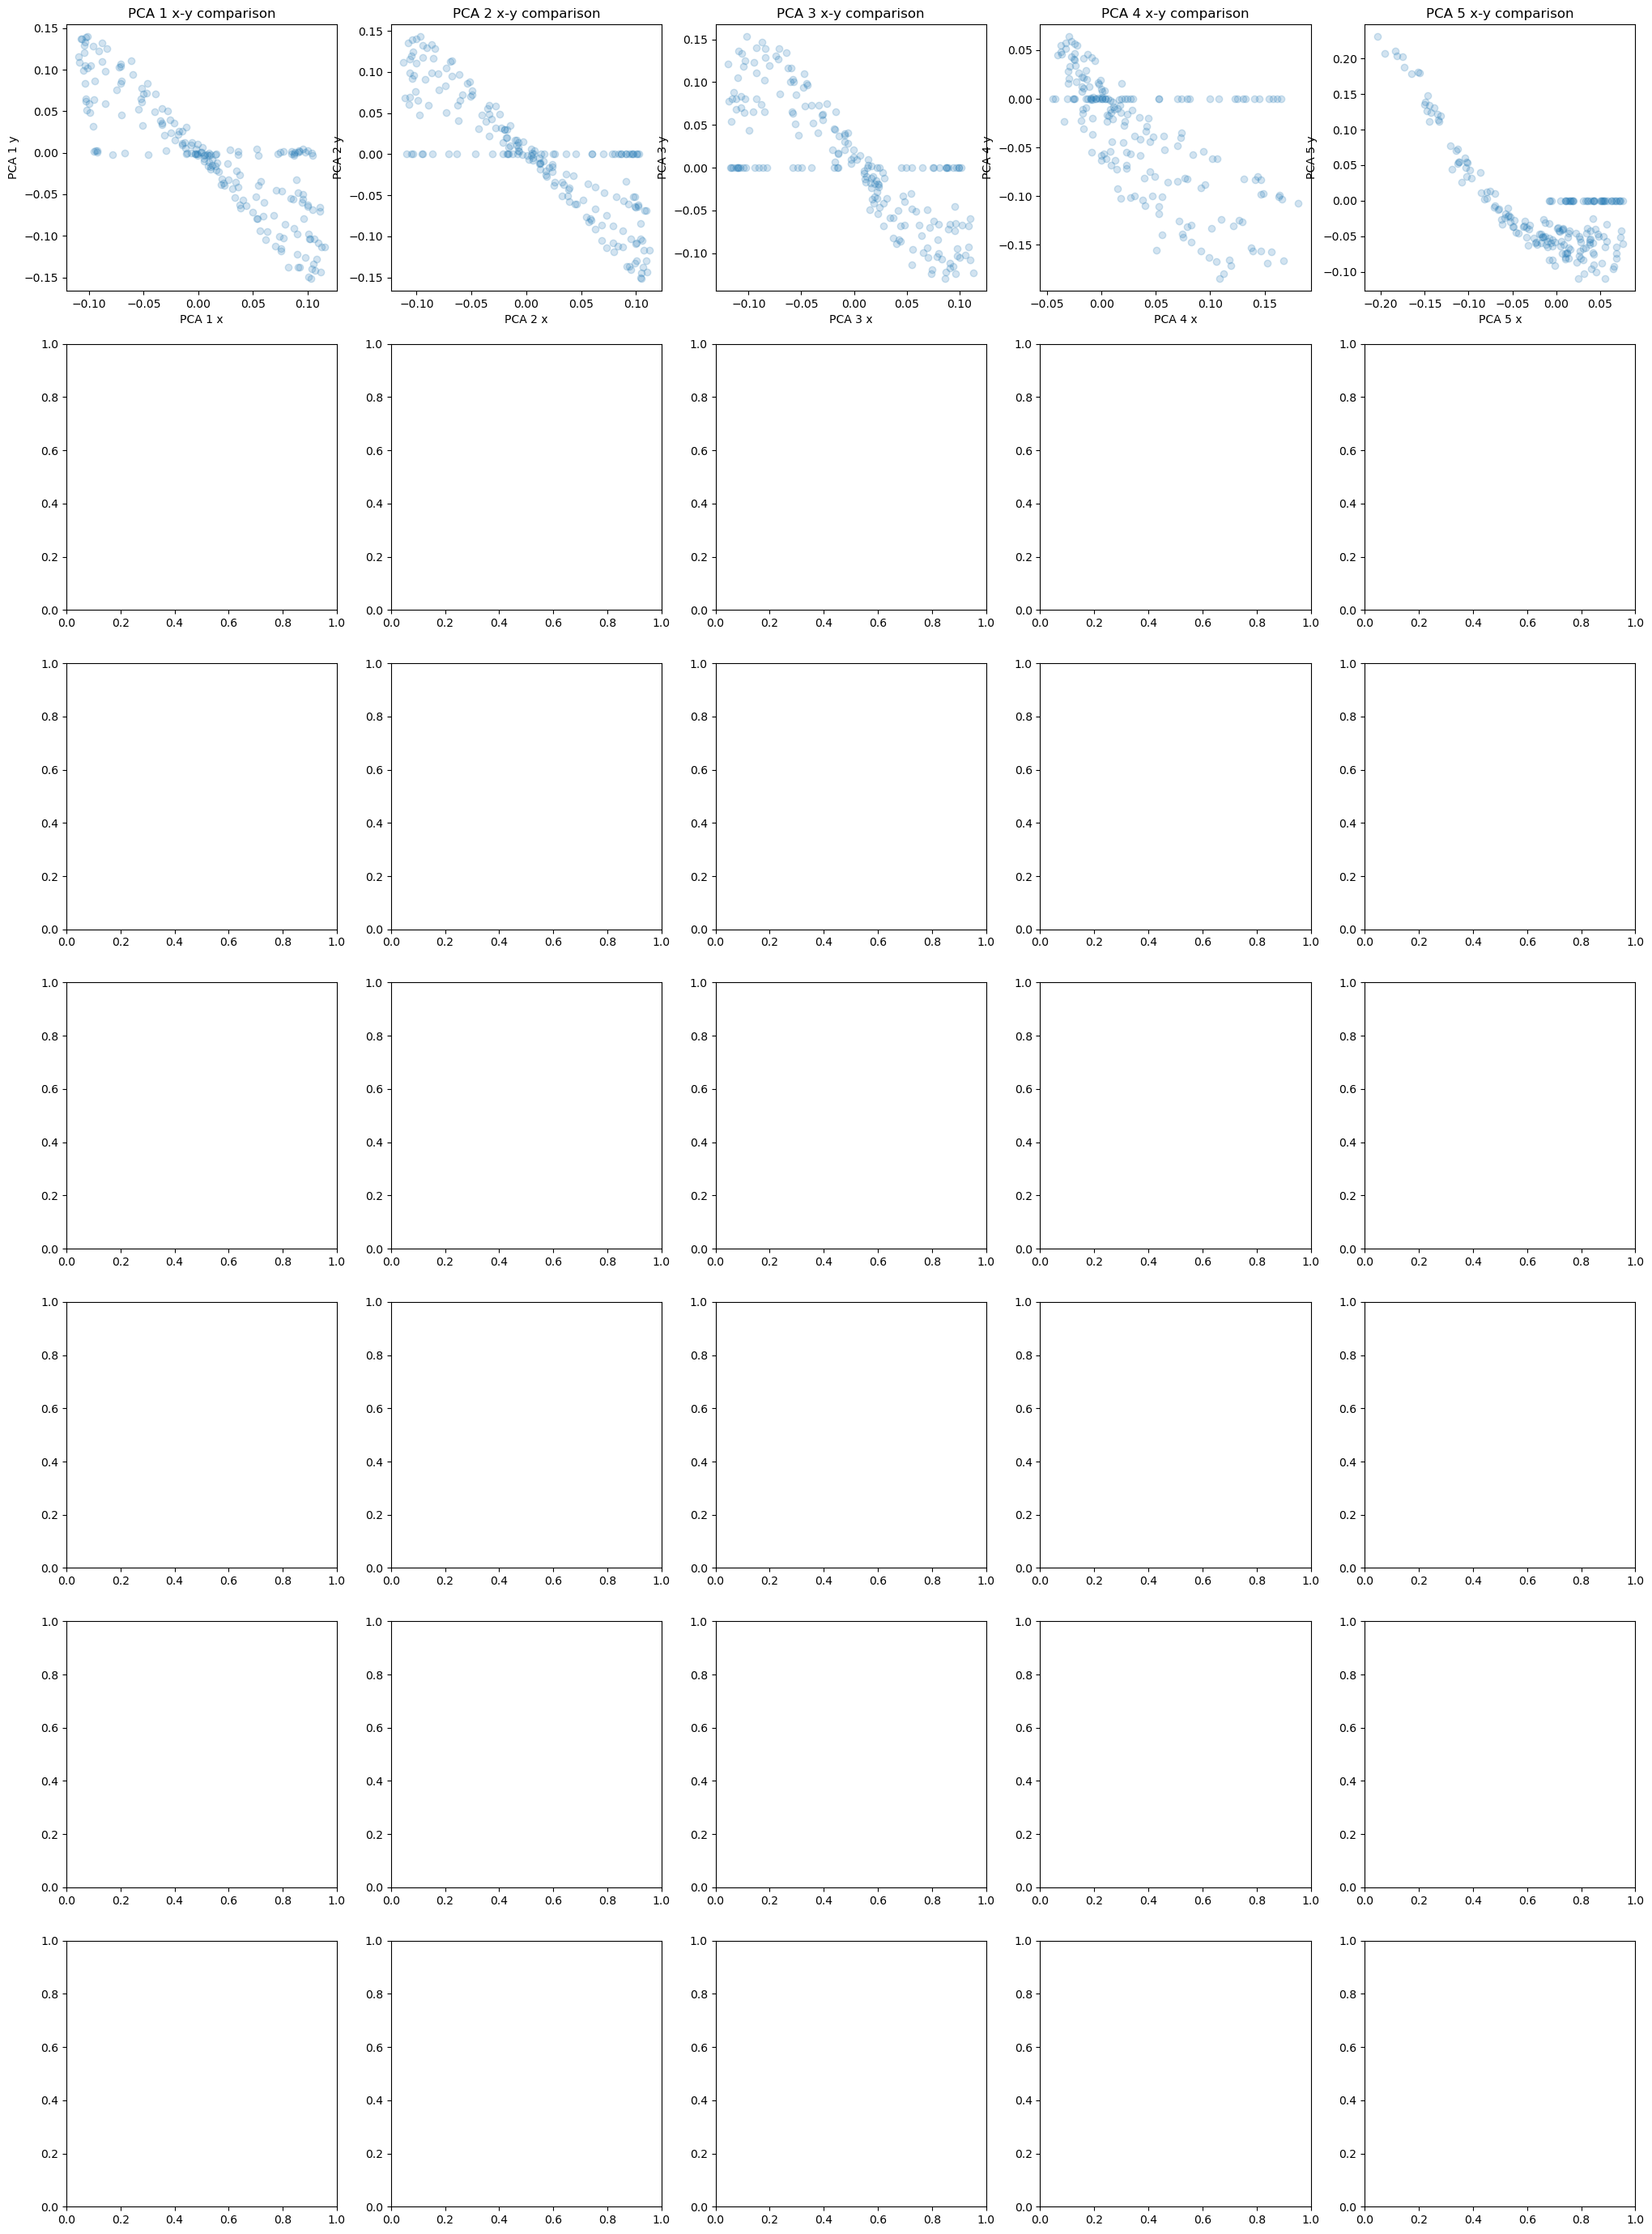

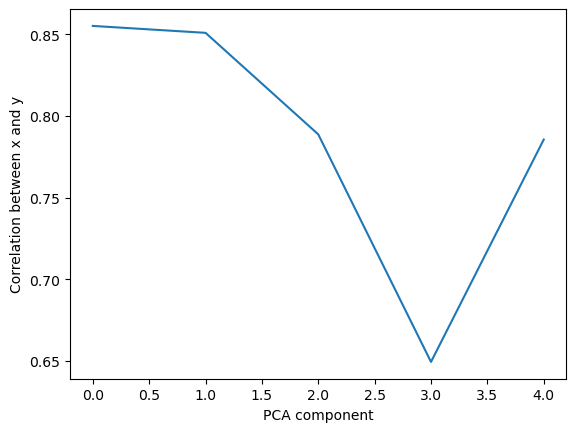

In [58]:
# parameter
rho = 50
n_components = 5
subset_size = 200
###########

w_opt, result_history, term_history = my_joint_PCA(x_train[:, :subset_size], y_train[:, :subset_size], rho = rho, n_components = n_components)
print(w_opt.shape)

# plotting weights
# fig, ax = plt.subplots(7, 10, figsize=(50, 35))
# ax = ax.flatten()

# for i in range(0, n_components*2, 2):
#     ax[i].imshow(w_opt[int(i/2), :x_train.shape[1]].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
#     ax[i].set_title(f"x PCA {int(i/2)+1}")
#     ax[i+1].imshow(w_opt[int(i/2), x_train.shape[1]:].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
#     ax[i+1].set_title(f"y PCA {int(i/2)+1}")
# plt.show()

# plotting weight correlations
corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, n_components):
    ax[i].plot(w_opt[i, :x_train[:, :subset_size].shape[1]], w_opt[i, x_train[:, :subset_size].shape[1]:], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(w_opt[i, :x_train[:, :subset_size].shape[1]], w_opt[i, x_train[:, :subset_size].shape[1]:])[0, 1])
plt.show()

plt.figure()
plt.plot(np.abs(corr_list))
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()


In [ ]:
# for i in range(5):
#     plt.figure()
#     plt.plot(x_train_pca[:, i], y_train_pca[:, i], 'o')
#     plt.show()

In [ ]:
## Train

n, m = 10, 10

model = full_model(n = n, m = m, ARD = False, multiinput = True, standardise = True, combine_pca = 'data')
model.fit(x_train, y_train)

does combined pca
does x pca
does y pca


  0%|          | 0/10 [00:00<?, ?it/s]

[1.]
float64
Optimization terminated successfully.
         Current function value: -261.429398
         Iterations: 39
         Function evaluations: 45
         Gradient evaluations: 45


 10%|█         | 1/10 [00:18<02:42, 18.01s/it]

Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.04399277], dtype=float64), variance=Array([19.9999976], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.15017722], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 20%|██        | 2/10 [00:44<03:02, 22.83s/it]

         Current function value: -100.774744
         Iterations: 35
         Function evaluations: 93
         Gradient evaluations: 83
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([13.46418858], dtype=float64), variance=Array([19.50041403], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.19311523], dtype=float64))
[2.]
[1.]
[1.]
float64


 30%|███       | 3/10 [01:02<02:26, 20.86s/it]

Optimization terminated successfully.
         Current function value: 63.419480
         Iterations: 42
         Function evaluations: 46
         Gradient evaluations: 46
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([20.84143179], dtype=float64), variance=Array([19.9999998], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.24027231], dtype=float64))
[2.]
[1.]
[1.]
float64


 40%|████      | 4/10 [01:22<02:02, 20.41s/it]

Optimization terminated successfully.
         Current function value: 27.789832
         Iterations: 38
         Function evaluations: 43
         Gradient evaluations: 43
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([19.21434914], dtype=float64), variance=Array([19.99999047], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.23050741], dtype=float64))
[2.]
[1.]
[1.]
float64


 50%|█████     | 5/10 [01:45<01:47, 21.43s/it]

Optimization terminated successfully.
         Current function value: 66.492605
         Iterations: 45
         Function evaluations: 50
         Gradient evaluations: 50
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.03622658], dtype=float64), variance=Array([19.99999997], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.21115833], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 60%|██████    | 6/10 [02:07<01:25, 21.49s/it]

         Current function value: -222.441519
         Iterations: 28
         Function evaluations: 70
         Gradient evaluations: 58
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.71542758], dtype=float64), variance=Array([18.29569813], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.16148502], dtype=float64))
[2.]
[1.]
[1.]
float64


 70%|███████   | 7/10 [02:22<00:57, 19.30s/it]

Optimization terminated successfully.
         Current function value: 185.818049
         Iterations: 30
         Function evaluations: 34
         Gradient evaluations: 34
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([13.25470296], dtype=float64), variance=Array([18.94939608], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.26252316], dtype=float64))
[2.]
[1.]
[1.]
float64


 80%|████████  | 8/10 [02:39<00:37, 18.80s/it]

Optimization terminated successfully.
         Current function value: 244.933541
         Iterations: 36
         Function evaluations: 40
         Gradient evaluations: 40
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([15.85713651], dtype=float64), variance=Array([19.99999017], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.28414375], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 90%|█████████ | 9/10 [02:57<00:18, 18.34s/it]

         Current function value: -183.982466
         Iterations: 14
         Function evaluations: 58
         Gradient evaluations: 47
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([13.85588999], dtype=float64), variance=Array([19.9981699], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.17708297], dtype=float64))
[2.]
[1.]
[1.]
float64


100%|██████████| 10/10 [03:09<00:00, 18.91s/it]

Optimization terminated successfully.
         Current function value: 40.627122
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.34280574], dtype=float64), variance=Array([3.26383973], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.19237342], dtype=float64))
[2.]
[1.]


In [ ]:
n_samples = 6

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

print(train_samples.shape)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


(1000, 10201, 6)
median relative L2 (train data): 0.4627730078194328
mean relative L2 (train data): 0.4668623316515533


(1000, 10201, 6)


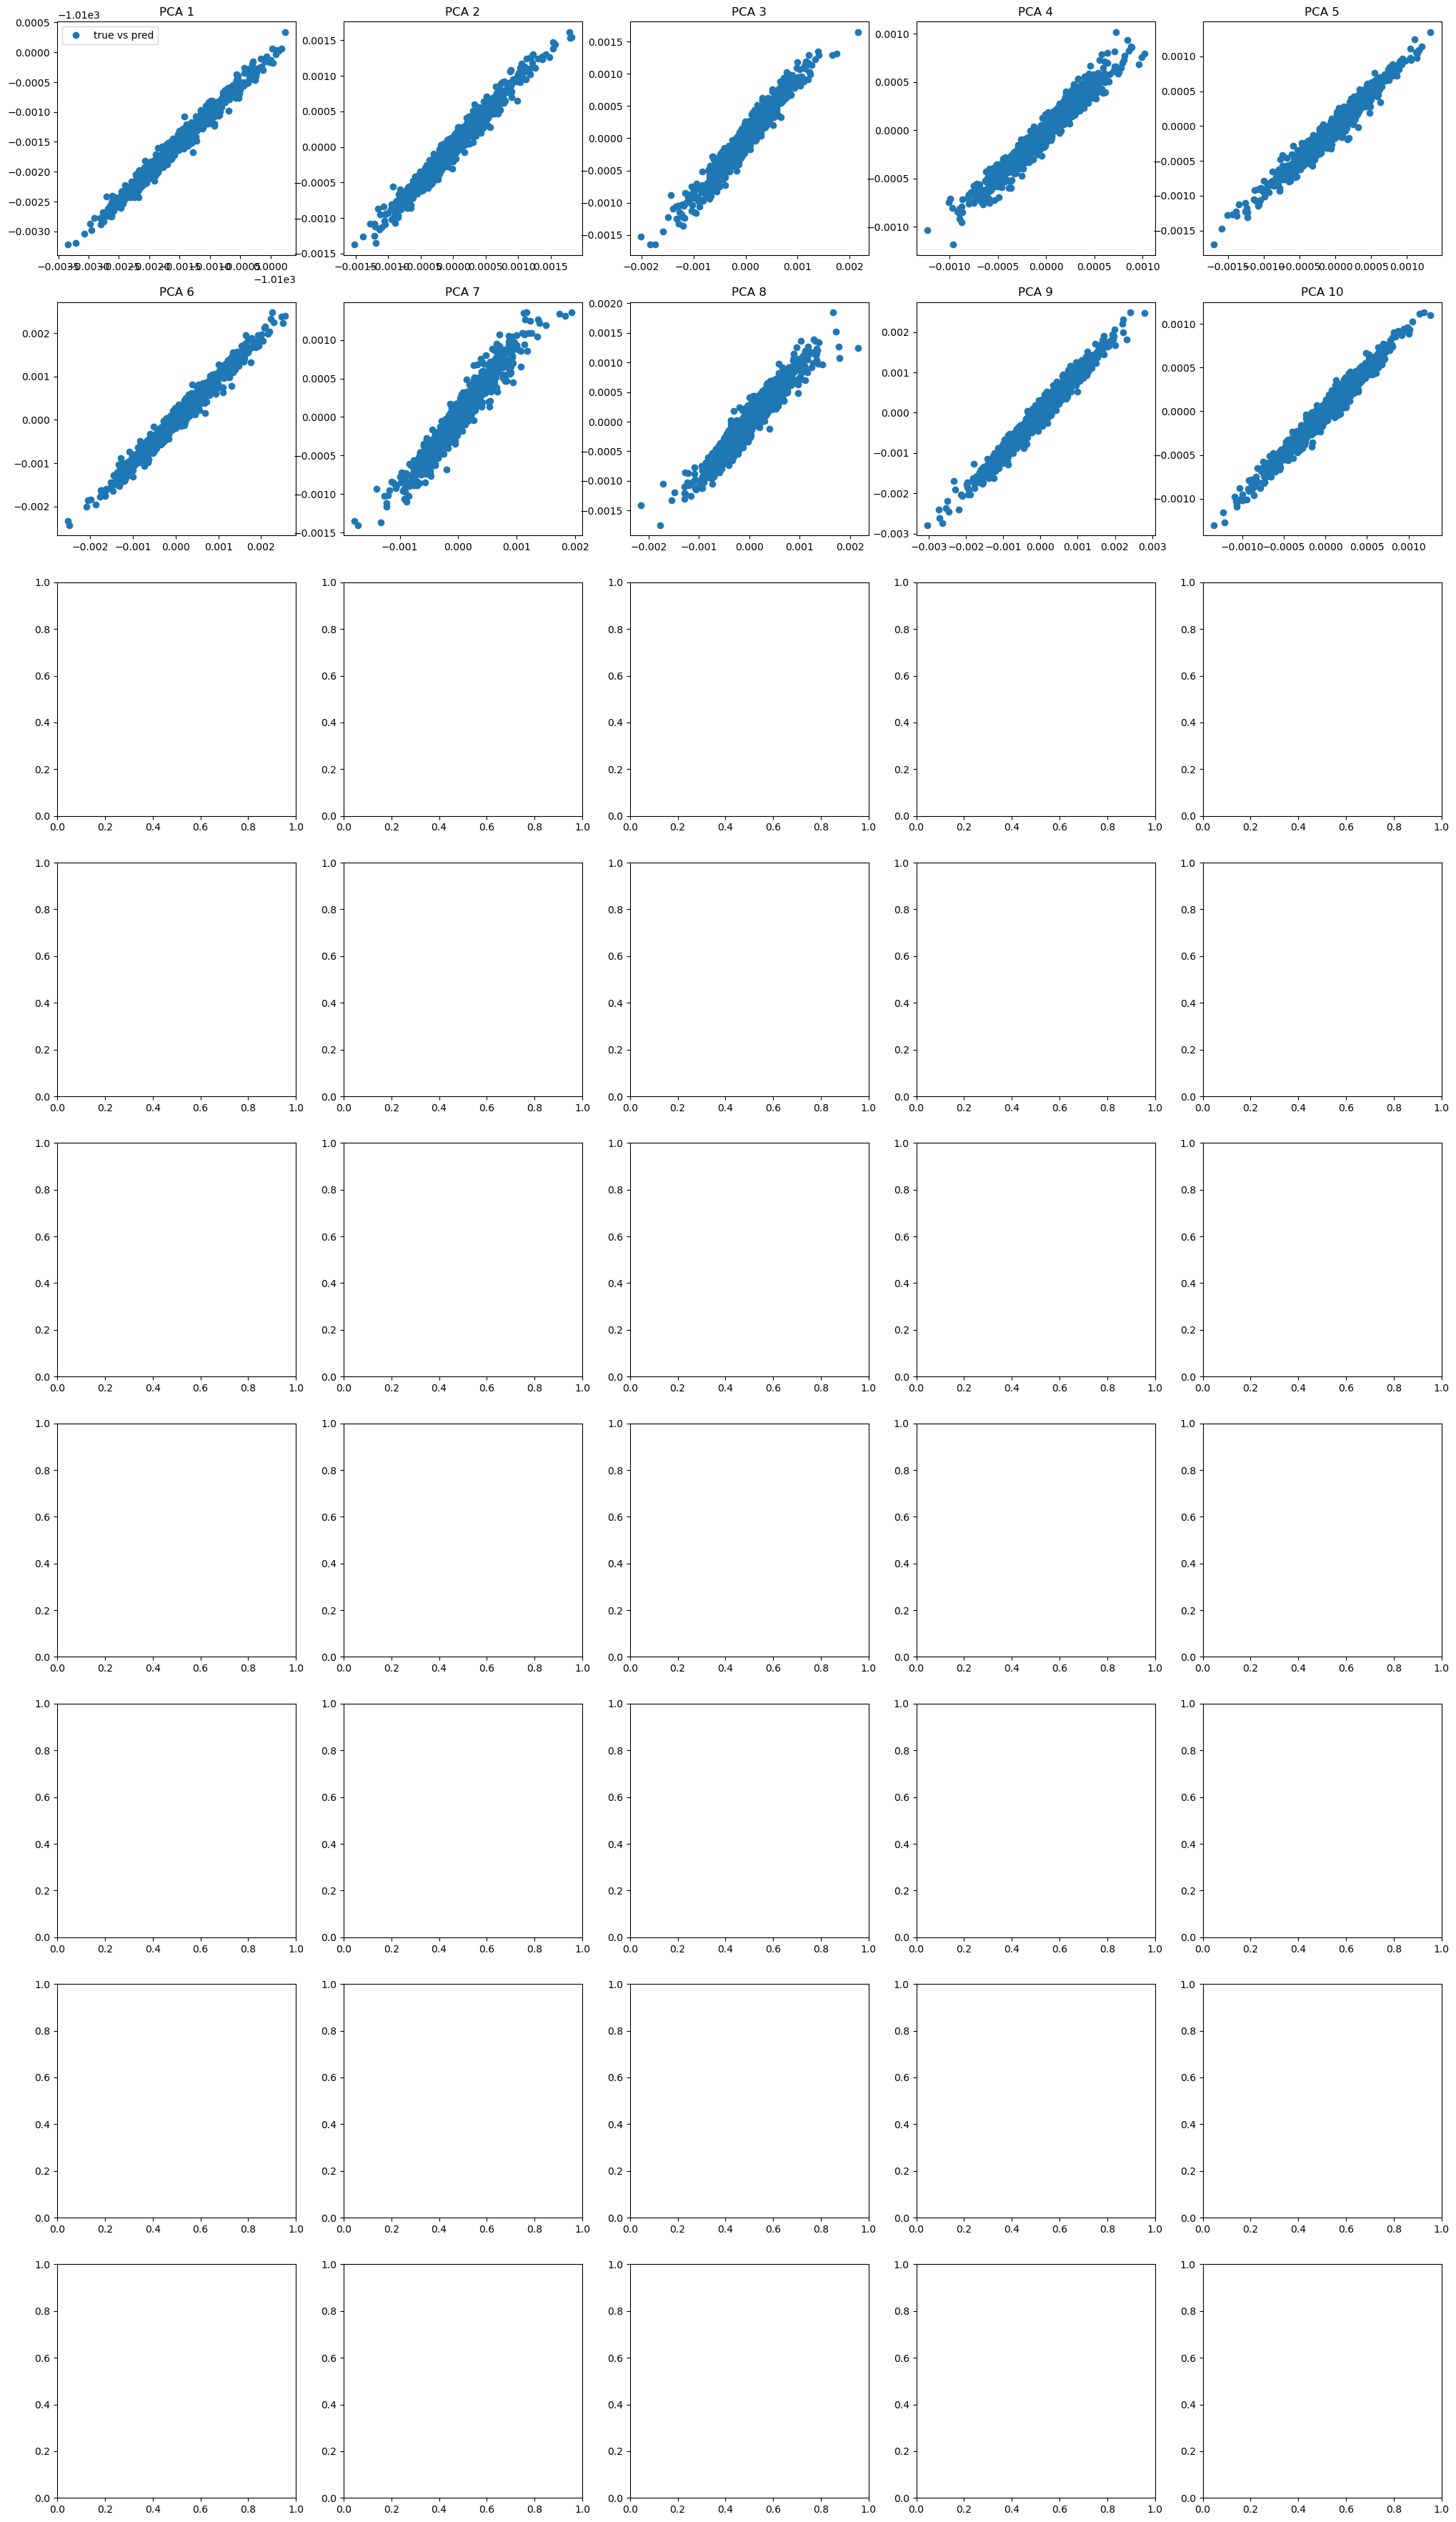

In [ ]:
x_train_pca = model.x_test_pca
y_train_pca = model.y_pca.transform(y_train)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_train_pca[:, i], model.y_pred_pca[:, 0, i], 'o', label = 'true vs pred')
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

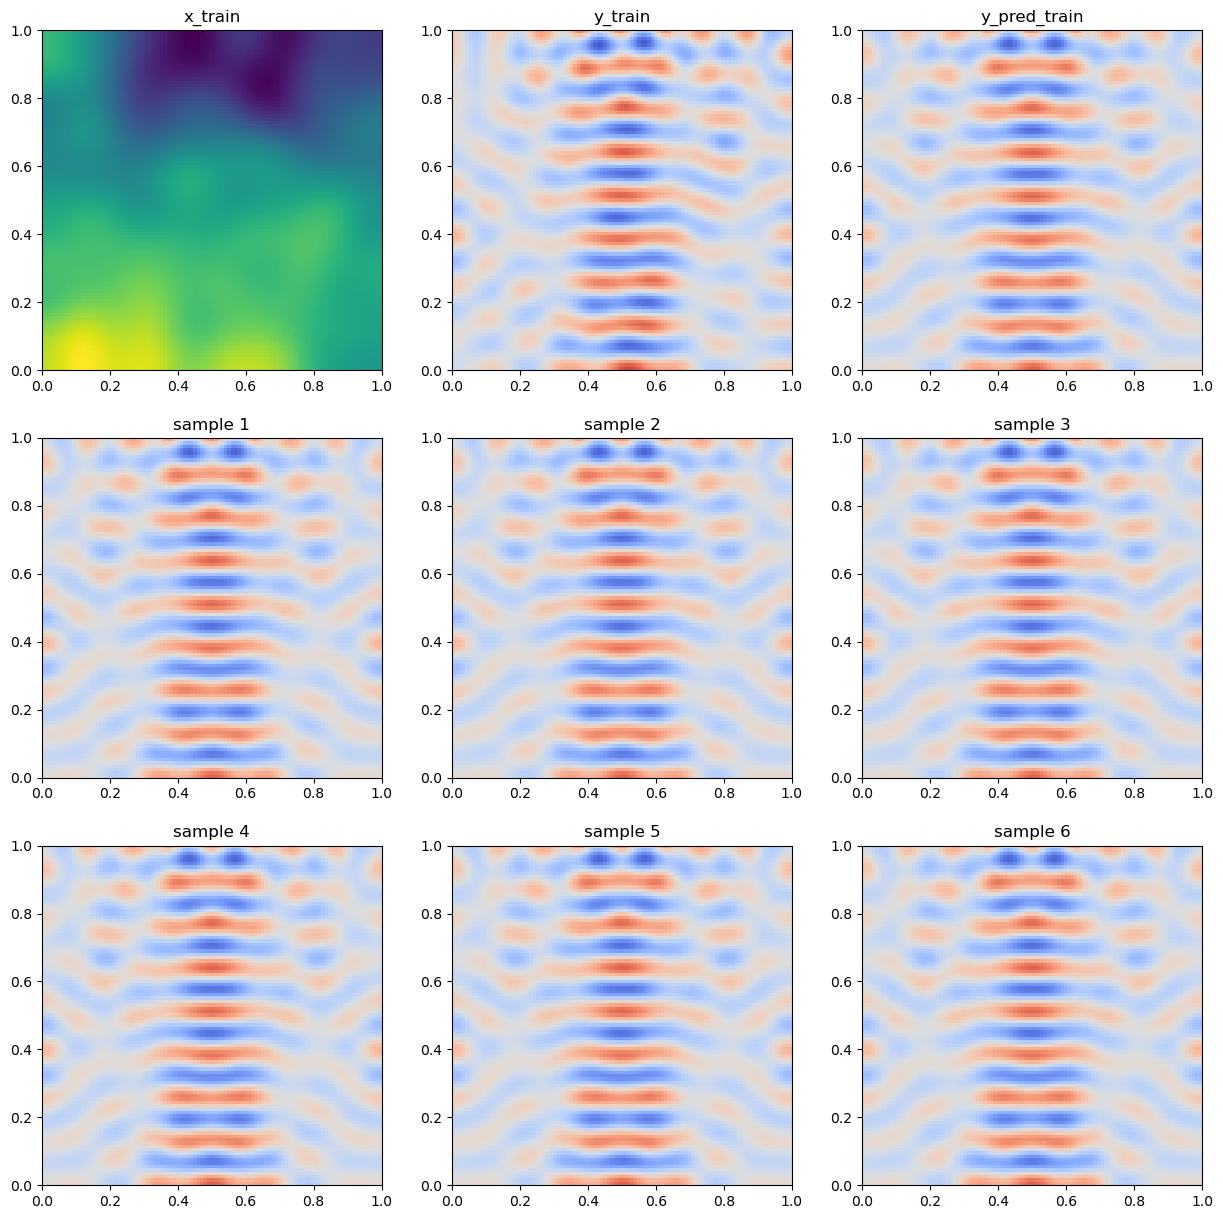

In [ ]:
index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_train[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_train[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap = x_cmap)
ax[0].set_title("x_train")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
ax[1].set_title("y_train")
im2 = ax[2].imshow(y_pred_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
ax[2].set_title("y_pred_train")
for i in range(6):
    imi = ax[i+3].imshow(train_samples[index_to_plot, :, i].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

# testing

In [ ]:
n_samples = 100

y_pred_test, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_test - y_test, axis = -1) / np.linalg.norm(y_test, axis = -1)

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


median relative L2: 0.461572574058597
mean relative L2: 0.46370298065320653


(1000, 10201, 6)


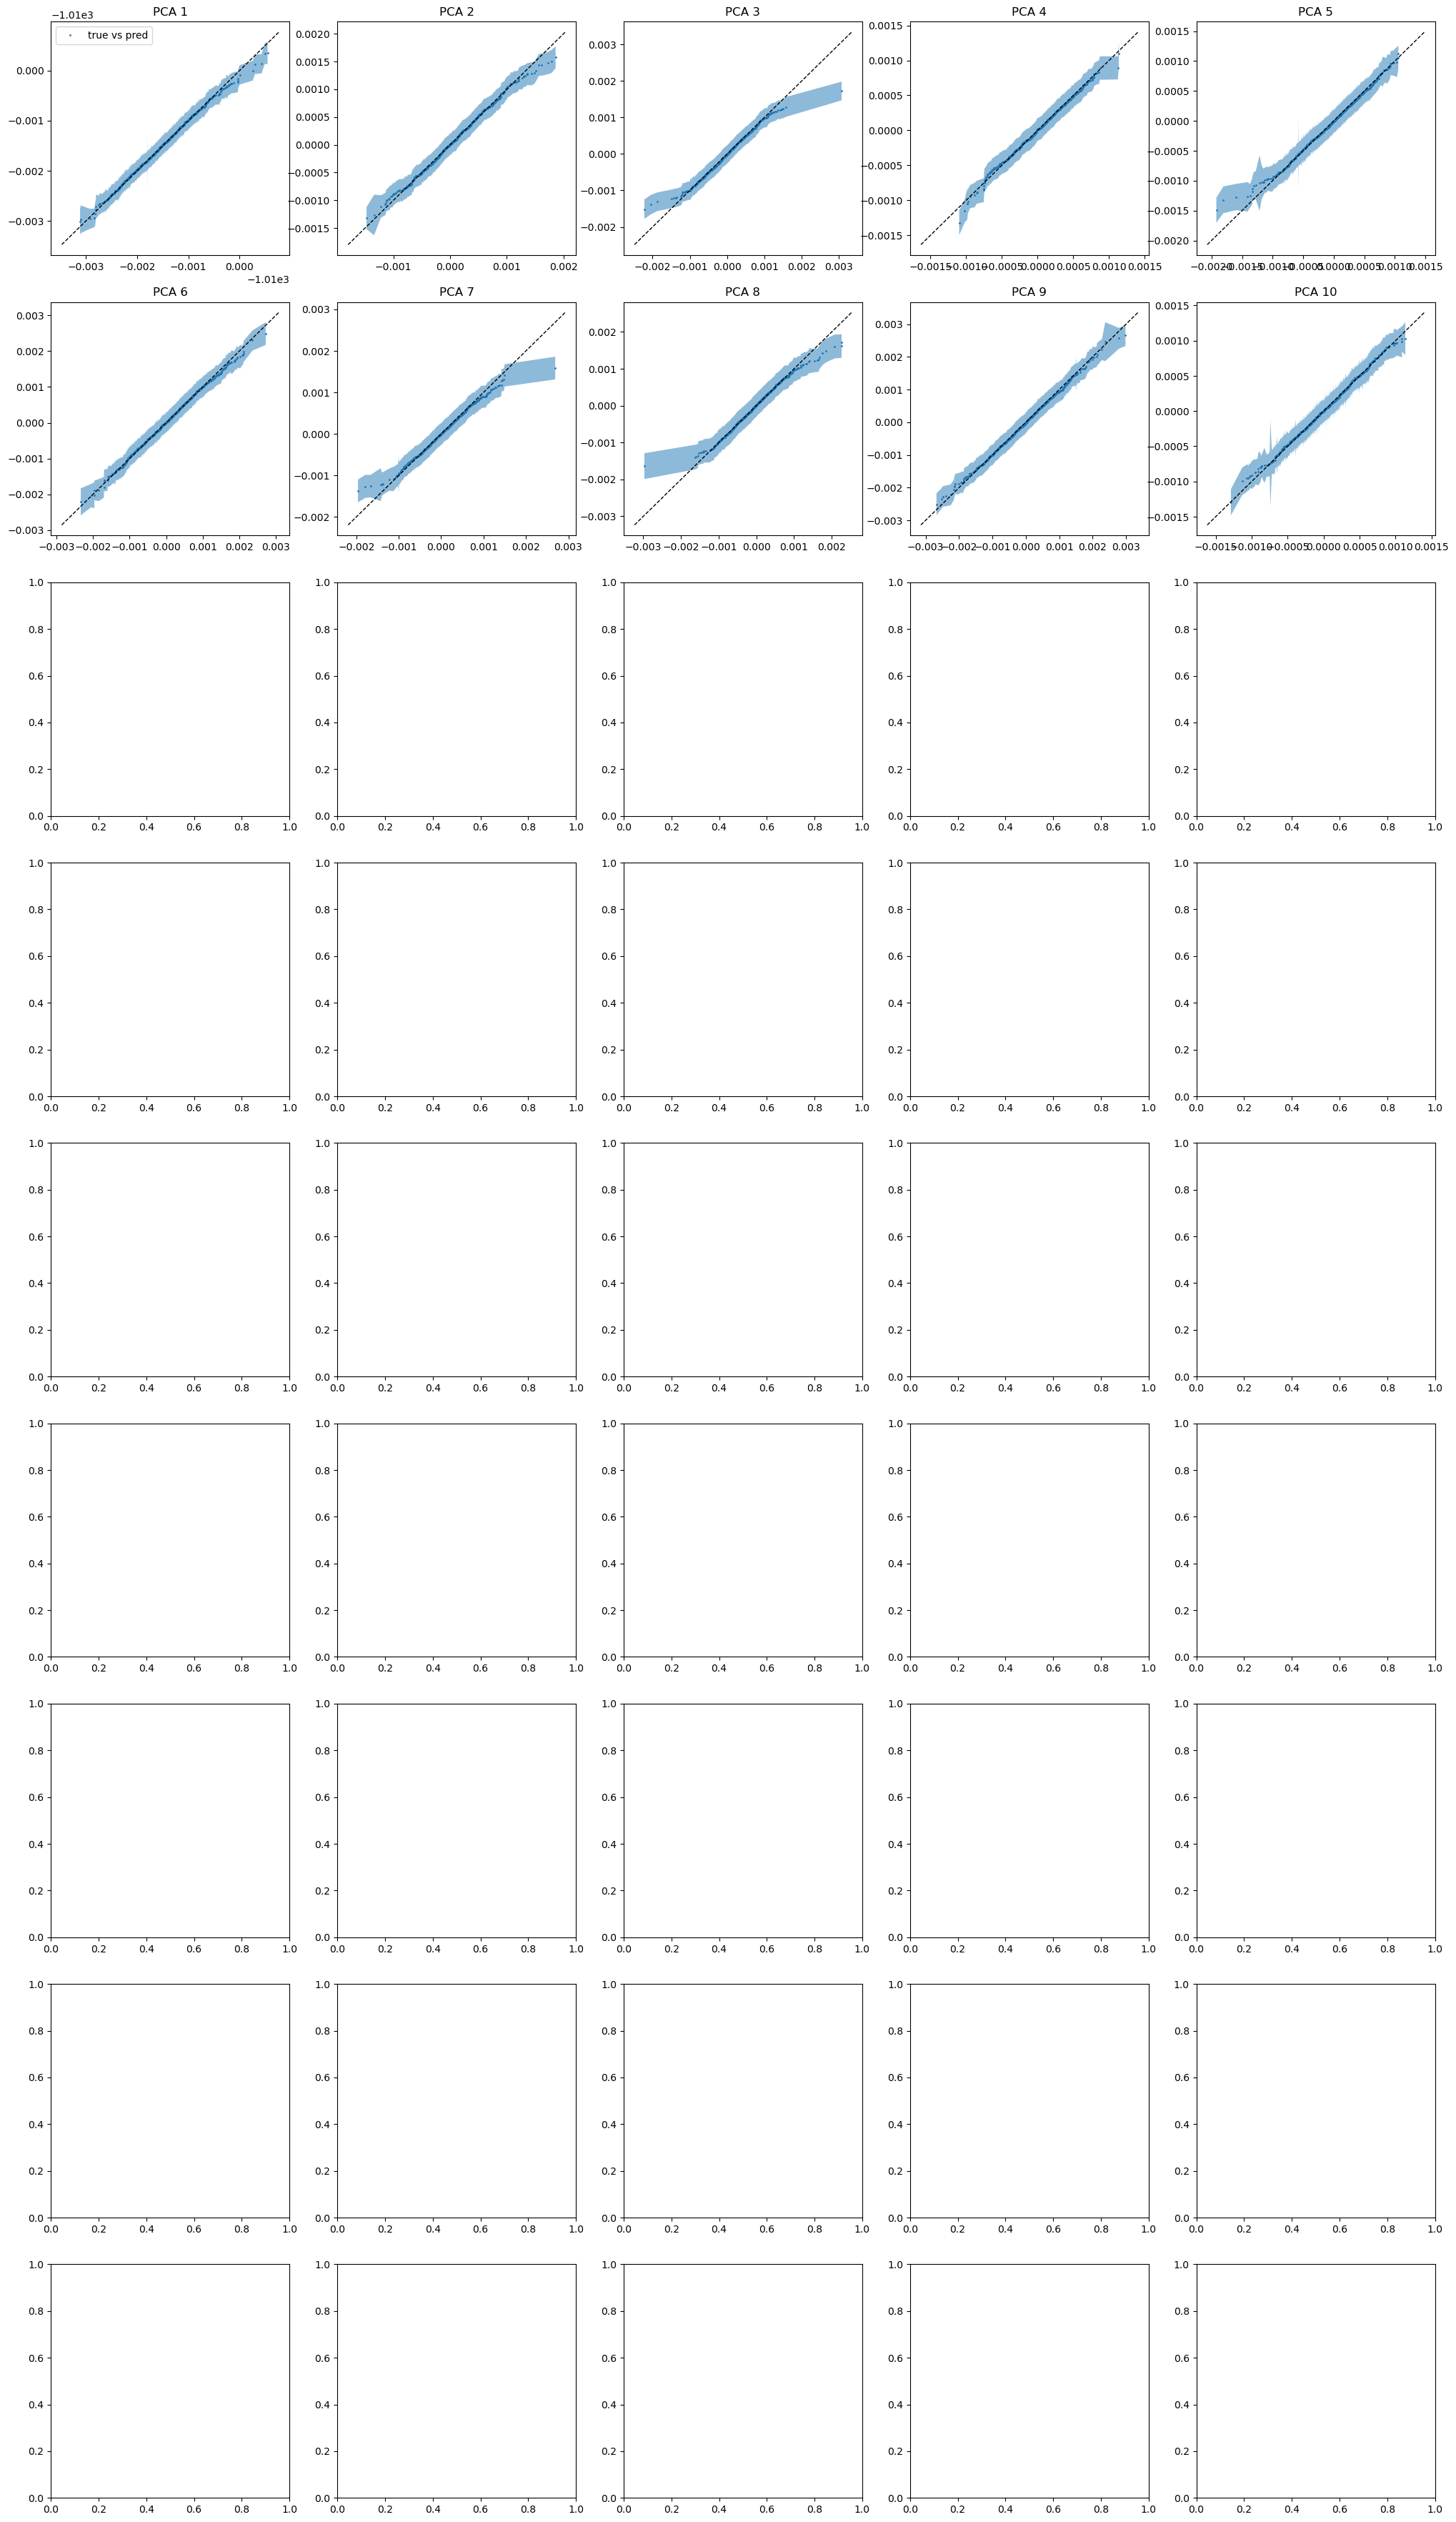

In [ ]:
x_test_pca = model.x_test_pca
y_test_pca = model.y_pca.transform(y_test)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_test_pca[:, i][np.argsort(y_test_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(model.y_pred_pca[:, 0, i])], 'o', label = 'true vs pred', ms = 1)
    ax[i].fill_between(y_test_pca[:, i][np.argsort(y_test_pca[:, i])], model.y_pred_pca[:, 1, i][np.argsort(model.y_pred_pca[:, 0, i])], model.y_pred_pca[:, 2, i][np.argsort(model.y_pred_pca[:, 0, i])], alpha = 0.5)
    # ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 1, i], 'o', label = r'true vs (pred - 2$\sigma$)')
    # ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 2, i], 'o', label = r'true vs (pred + 2$\sigma$)')
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()

    min_val = min(xlim[0], ylim[0])
    max_val = max(xlim[1], ylim[1])

    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

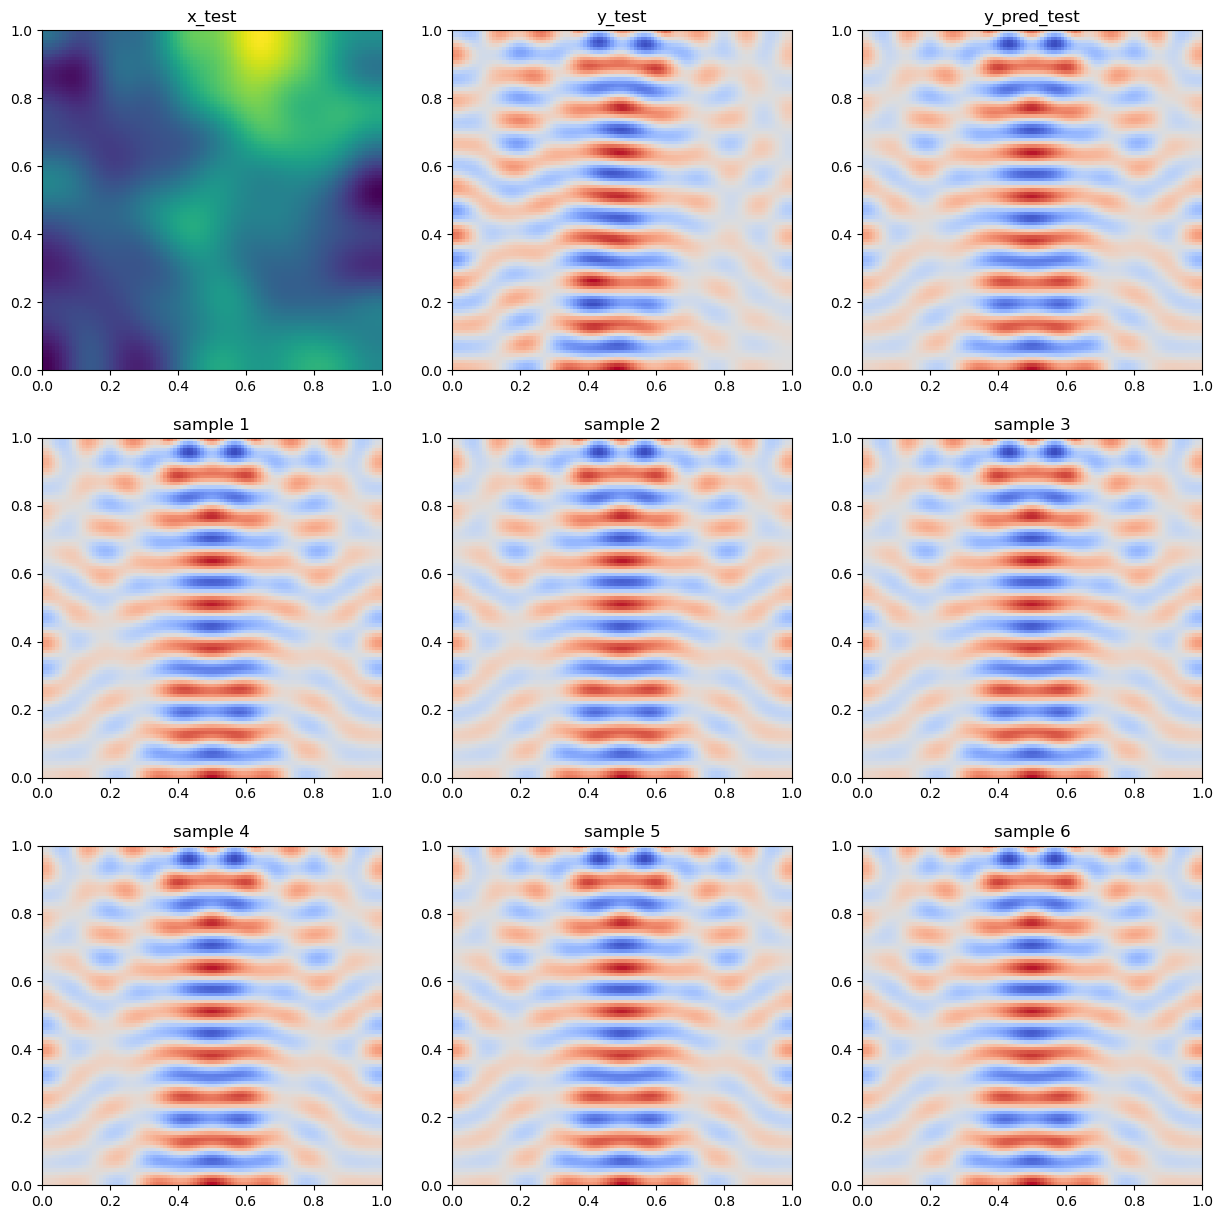

In [ ]:
index_to_plot = 125

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_test[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_test[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap = x_cmap)
ax[0].set_title("x_test")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
ax[1].set_title("y_test")
im2 = ax[2].imshow(y_pred_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
ax[2].set_title("y_pred_test")
for i in range(6):
    imi = ax[i+3].imshow(test_samples[index_to_plot, :, i].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

## analyse uncertainty

In [ ]:
print(test_samples.shape)

test_samples_mean = np.mean(test_samples, axis = 2)
test_samples_std = np.std(test_samples, axis = 2)

(1000, 10201, 100)


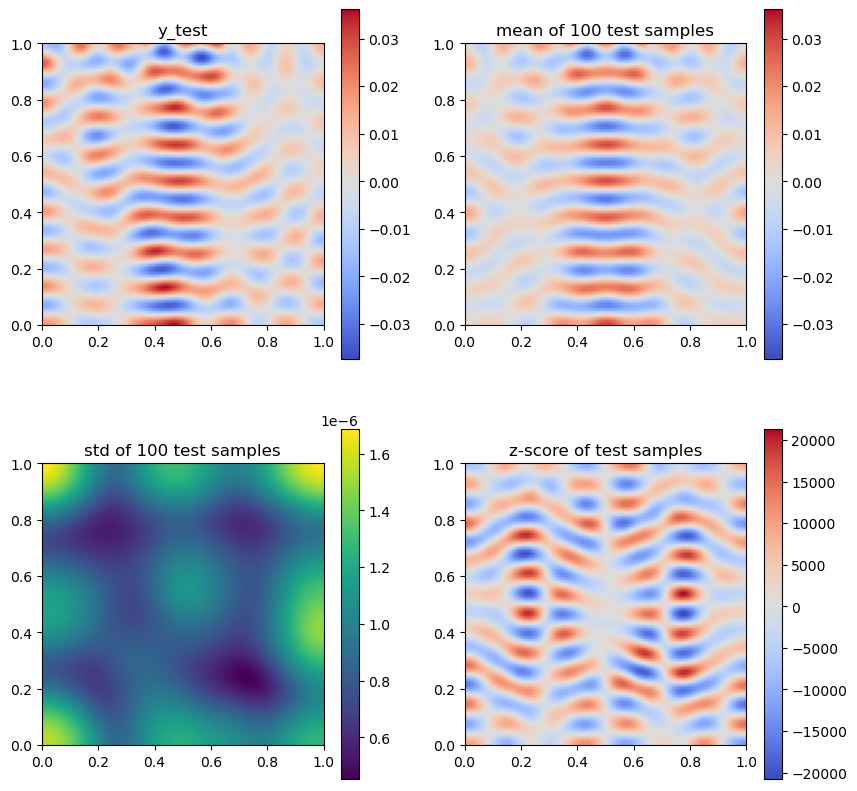

In [ ]:
index_to_plot = 1

y_lims = np.array([min(y_test[index_to_plot, :].min(), test_samples_mean[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), test_samples_mean[index_to_plot, :].max())])

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.flatten()

im0 = ax[0].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
ax[0].set_title("y_test")
im1 = ax[1].imshow(test_samples_mean[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
ax[1].set_title(f"mean of {n_samples} test samples")
im2 = ax[2].imshow(test_samples_std[index_to_plot, :].reshape(s, s), origin='lower', extent=extent)
ax[2].set_title(f"std of {n_samples} test samples")
im3 = ax[3].imshow((y_test[index_to_plot, :].reshape(s, s) - test_samples_mean[index_to_plot, :].reshape(s, s)) / test_samples_std[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap = 'coolwarm')
ax[3].set_title(f"z-score of test samples")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])


Linear regression baseline

1000 128
0.10237320983538317 0.11867839288962274


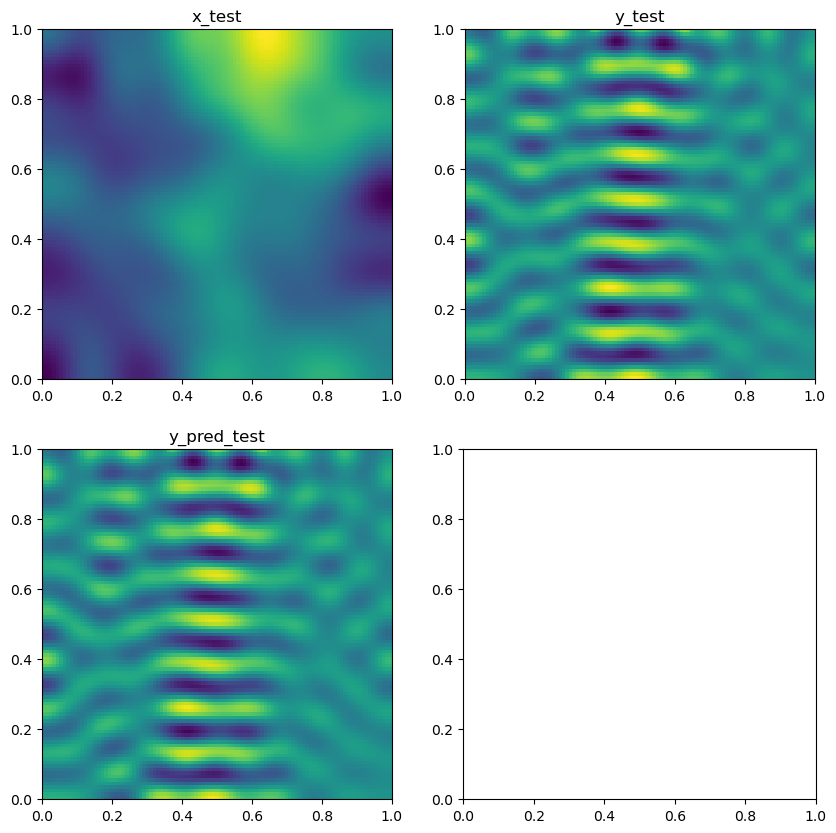

1000 256
0.09654863252019955 0.13610327183221277


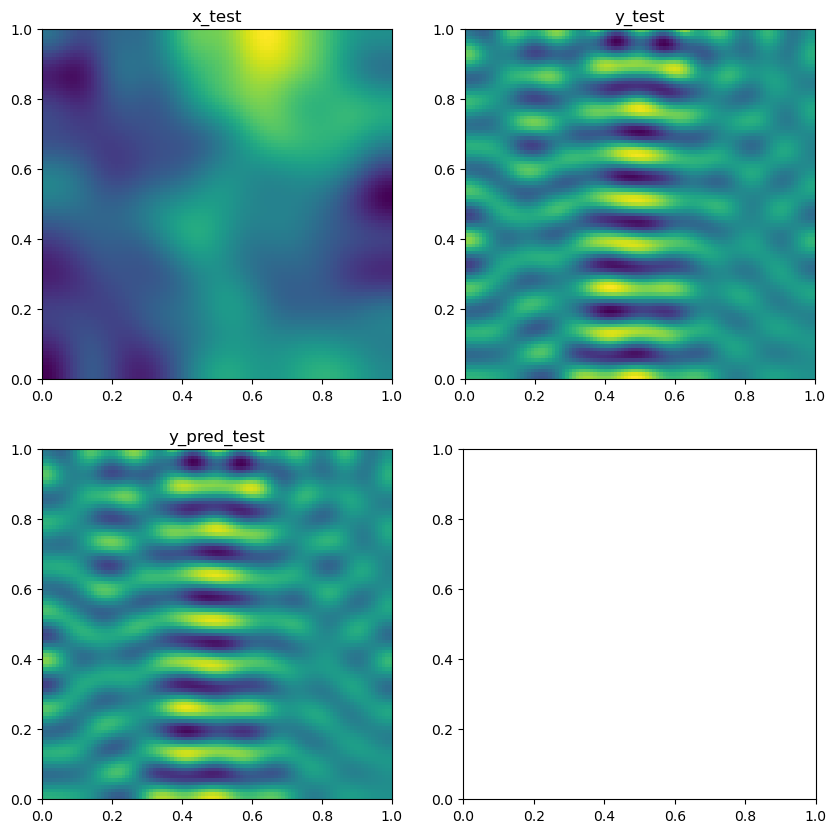

1000 512
0.08052089880378878 0.1764737058195088


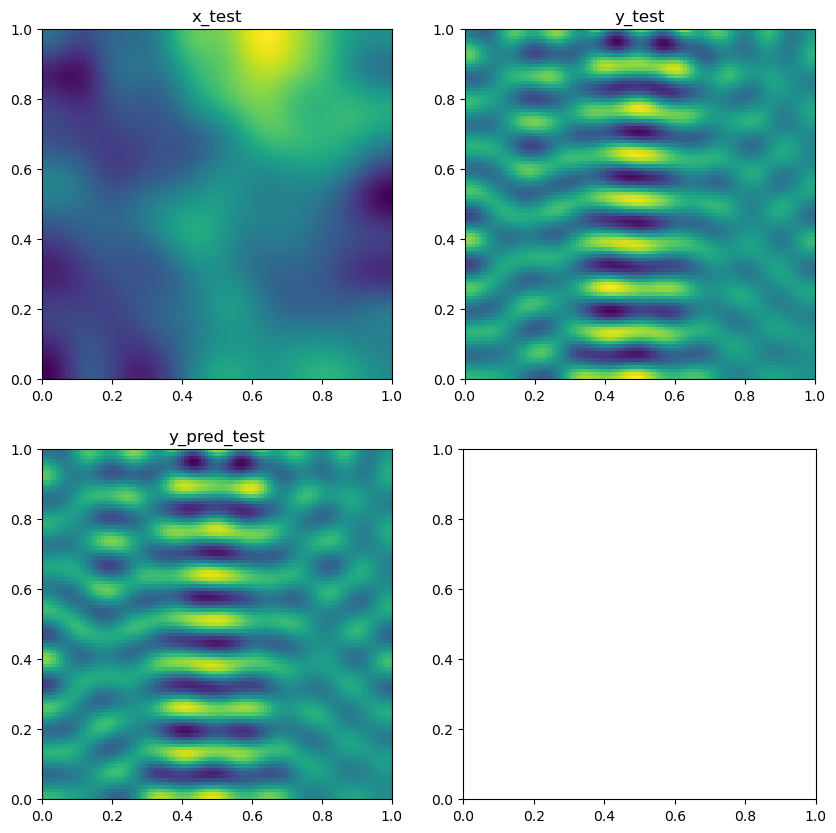

1000 1024
7.409469899050793e-10 0.5303063303091085


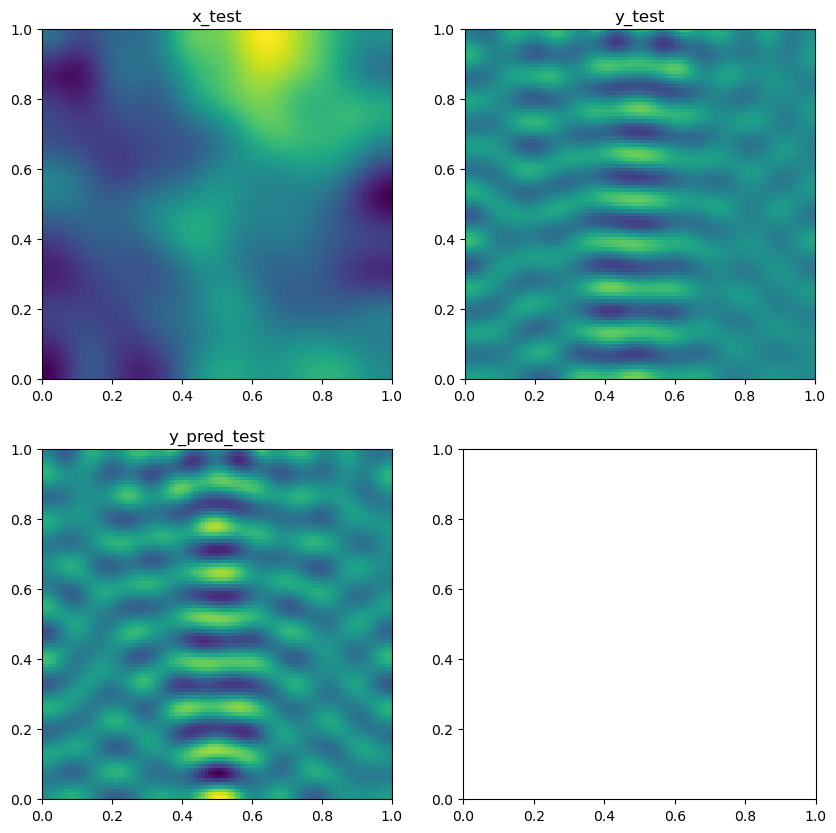

In [ ]:
results = []
for Ntrain in [1000]:
    for N_components in [128, 256, 512, 1024]:
        print(Ntrain, N_components)
        Ytr = y_train
        Xtr = x_train
        pca = PCA(n_components=min(N_components,Ntrain))
        Xtr = pca.fit_transform(Xtr)
        reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
        #Ypred Ypredtr = reg.predict(Xtr)
        Ypredtr = reg.predict(Xtr)
        train_error = np.mean(np.linalg.norm(Ypredtr-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
        Xtest = x_test
        Ytest = y_test
        Xtest = pca.transform(Xtest)
        Ypred = reg.predict(Xtest)
        test_error = np.mean(np.linalg.norm(Ypred-Ytest, axis = 1)/np.linalg.norm(Ytest, axis = 1))
        print(train_error, test_error)
        results.append([Ntrain, N_components, train_error, test_error])

        index_to_plot = 125

        y_lims = np.array([min(y_test[index_to_plot, :].min(), Ypred[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), Ypred[index_to_plot, :].max())])

        fig, ax = plt.subplots(2, 2, figsize = (10, 10))
        ax = ax.flatten()
        im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent)
        ax[0].set_title("x_test")
        im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[1].set_title("y_test")
        im2 = ax[2].imshow(Ypred[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[2].set_title("y_pred_test")
        plt.show()

results = np.array(results)